# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [3]:
from vanna.utils import snake_case

In [4]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [5]:
model_name = 'deepseek-r1' # 'deepseek-coder-v2' # "codegeex4" # "llama3" # "qwen2.5" # 
CONFIG = {
    'model': model_name,   
}

file_db = "~/Downloads/datasets/chinook.db"


clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [6]:
snake_case(model_name)

'deepseek_r1'

In [7]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

In [8]:
vn = MyVanna(config=CONFIG)

In [9]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [10]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [11]:
vn.run_sql_is_set

True

In [12]:
if clean_and_train:
    vn.remove_collection()

In [13]:
vn.dataset

'default'

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [14]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [15]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [16]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)




Adding ddl: CREATE TABLE "albums"
(
    [AlbumId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    FOREIGN KEY ([ArtistId]) REFERENCES "artists" ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE sqlite_sequence(name,seq)


Adding ddl: CREATE TABLE "artists"
(
    [ArtistId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Name] NVARCHAR(120)
)


Adding ddl: CREATE TABLE "customers"
(
    [CustomerId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    FOREIGN KEY ([SupportRepId]) REFERENCES "employees" ([EmployeeId]) 
		ON DELETE NO

In [17]:
# show training data
training_data = vn.get_training_data()
training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
6,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation
7,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
8,38197d19-a90b-5ebe-b51d-eeee8760b334-ddl,default,None,"CREATE TABLE ""playlist_track""\r\n(\r\n Play...",ddl
9,4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl,default,None,"CREATE INDEX IFK_TrackAlbumId ON ""tracks"" (Alb...",ddl


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(CustomerId) AS NumberOfCustomers 
FROM "customers";


[( <SQL> )]
generated SQL statement



SELECT COUNT(CustomerId) AS NumberOfCustomers 
FROM "customers";


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Okay, so I need to help the user generate Plotly code to chart their DataFrame. Let's break down what they're asking for.

First, the user provided a pandas DataFrame that comes from a query counting customers, and it has one column: NumberOfCustomers. The data types are int64, which makes sense because it's a count.

They want a Python Plotly plot. I know Plotly is great for creating interactive visualizations. Since the DataFrame might have more than 20 rows, they mentioned using df.head(20) to limit the data. That way, we only show the first 20 entries, which should be manageable and probably sufficient for visualization.

If there's only one value in the DataFrame, they want an Indicator. Hmm, I'm not exactly sure what that means here. Maybe it's a specific type of chart when there's just one data point? But looking at their query, it's counting customers, so unless all rows have the same count, which is unlikely, maybe this condition isn't necessary for their case. But since they included it in the instructions, I should consider including that check.

So, the plan is: create a figure using Plotly Express. If there's only one unique value in NumberOfCustomers, use an Indicator. Otherwise, plot a bar chart showing each row as a separate bar.

Wait, but if we take df.head(20), even if the original DataFrame has more than 20 rows, taking the first 20 might result in multiple rows with the same count. So, checking for uniqueness is important to decide between an Indicator and a bar chart.

Putting it all together, I'll write code that checks if len(df['NumberOfCustomers'].unique()) == 1. If yes, create an Indicator; else, use a bar plot of df.head(20).

I should make sure the code uses Plotly Express functions correctly. For the bar plot, x parameter will be the index since each row is a separate entry. For the Indicator, I'll need to specify the y trace with the count and set appropriate layout parameters.

So, putting it all into code: first, check for uniqueness, then create either an Indicator or a bar chart using Plotly Express's functions.
</think>

```python
import plotly.express as px

if len(df['NumberOfCustomers'].unique()) == 1:
    fig = px-indicator(value=df['NumberOfCustomers'].

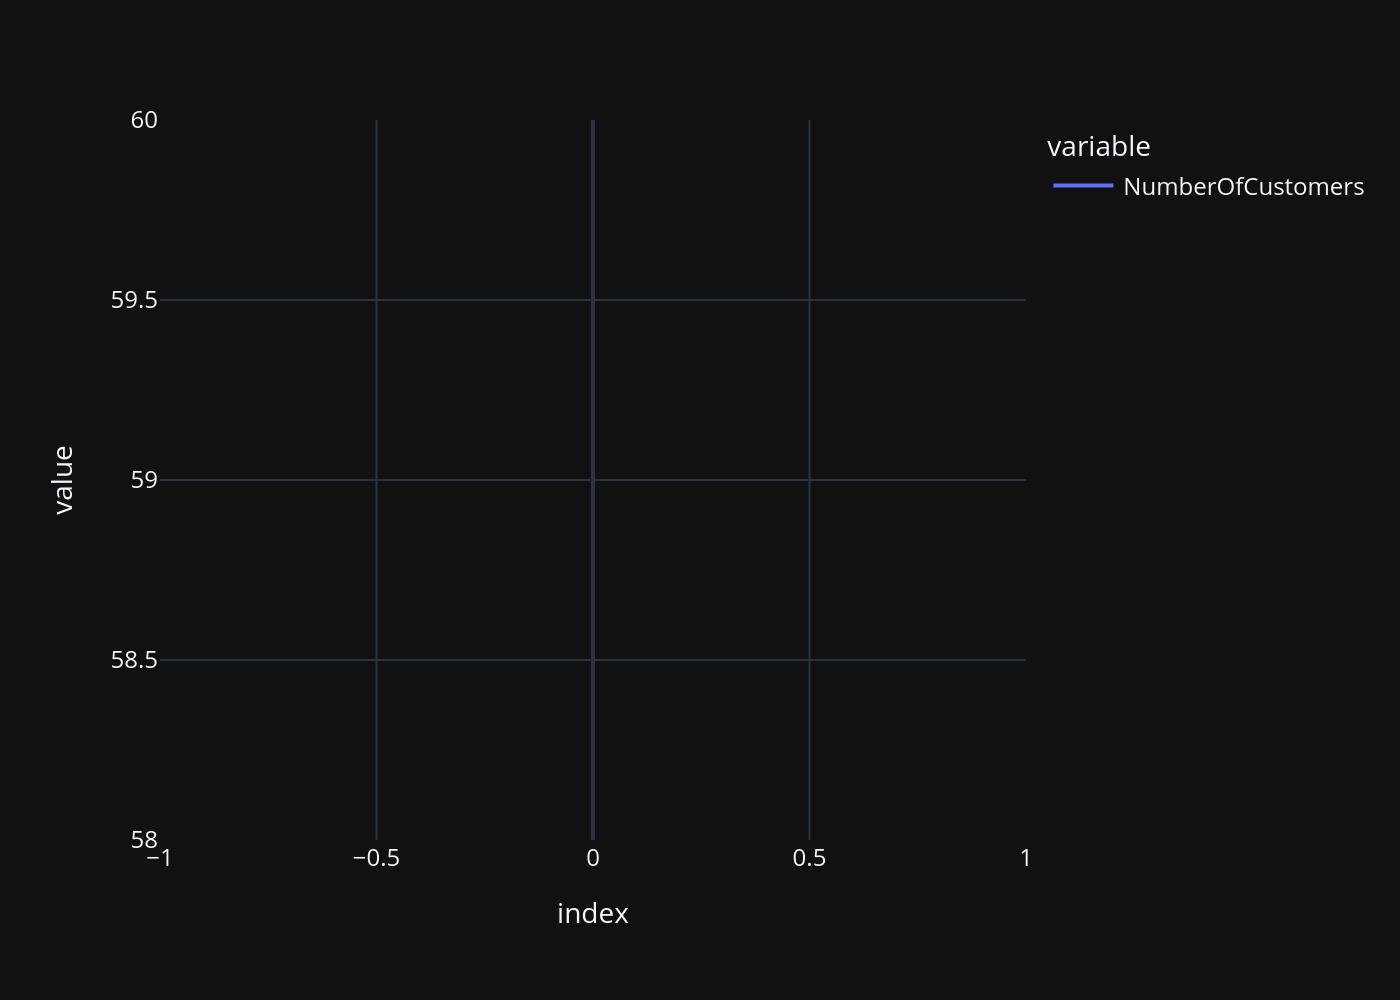

elapsed_time = 31.633378267288208


In [18]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

```sql

SELECT name FROM sqlite_master WHERE type = 'table';

```

```sql

SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [15]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with tables where data is stored. So, if I have an SQLite database file, like "mydatabase.db", there should be some tables inside it.

I remember seeing something about SQL commands for databases. Maybe I can use the `sqlite3` tool or Python's sqlite module to interact with the database. But since I'm just starting out, perhaps using a simple command-line tool would be easier.

Wait, I think SQLite has its own set of commands that you can run directly from the terminal without needing to write a full-fledged application. Maybe there's a command like `sqlite3` where you can specify the database file and then list the tables.

Let me try to recall: If I open the termina

with tables where data is stored. So, if I have an SQLite database file, like "mydatabase.db", there should be some tables inside it.

I remember seeing something about SQL commands for databases. Maybe I can use the `sqlite3` tool or Python's sqlite module to interact with the database. But since I'm just starting out, perhaps using a simple command-line tool would be easier.

Wait, I think SQLite has its own set of commands that you can run directly from the terminal without needing to write a full-fledged application. Maybe there's a command like `sqlite3` where you can specify the database file and then list the tables.

Let me try to recall: If I open the terminal and type `sqlite3 mydatabase.db`, it should let me interact with the database using SQL commands. Then, typing `.schema;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with databases without needing to write a full-fledged application. Maybe there's a command like `sqlite3` where you can specify the database file and then list the tables.

First, I need to open my terminal or command prompt. Then, I think I should type something like `sqlite3 mydatabase.db`. Once that's done, it should bring up an interactive SQL shell for that specific database. 

In this interactive shell, I believe there are commands to list all the tables in the database. Maybe it's a `.schema` or `.tables` command? Let me try typing `.schema limit 20` and see what happens.

If that doesn't work, perhaps I need to use another approach. Maybe writing a simple Python script using the sqlite module could help. I can

with databases without needing to write a full-fledged application. Maybe there's a command like `sqlite3` where you can specify the database file and then list the tables.

First, I need to open my terminal or command prompt. Then, I think I should type something like `sqlite3 mydatabase.db`. Once that's done, it should bring up an interactive SQL shell for that specific database. 

In this interactive shell, I believe there are commands to list all the tables in the database. Maybe it's a `.schema` or `.tables` command? Let me try typing `.schema limit 20` and see what happens.

If that doesn't work, perhaps I need to use another approach. Maybe writing a simple Python script using the sqlite module could help. I can import sqlite as sqlite, create a connection to my database, and then execute a query to list all tables.

Alternatively, if I'm comfortable with SQL syntax, I can write an SQL statement directly in the terminal that selects all table names from the `schema` of the database. But since I'm just starting out, using a command-line tool like `sqlite3` seems more straightforward and less error-prone for now.
</think>

To list all tables in your SQLite database "mydatabase.db", you can use the following SQL command:

```bash
sqlite3 mydatabase.db .schema limit 20
```

This will display information about each table, including their names. If this doesn't work, try using a different approach like writing a Python script or executing an SQL query directly in the terminal.

Alternatively, you can use the following SQL statement to list all tables:

```sql
SELECT name FROM sqlite_master WHERE type = 'table';


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with databases without having to write full-fledged applications. Maybe there's a command like `sqlite3` where you can specify the database and then get information about it.

I think the first step is to open my terminal or command prompt and type something like `sqlite3 mydatabase.db`. Once I'm inside the SQLite shell, I should be able to run SQL commands directly. But when I tried typing `.schema limit 20`, it gave me an error saying "with tables where data is stored". Hmm, that doesn't make much sense.

Wait, maybe I misremembered the command. Perhaps instead of `.schema`, there's a different way to list tables. I think there might be a `.table` command or something similar. Let me try typing `PRAGMA table_info;




with databases without having to write full-fledged applications. Maybe there's a command like `sqlite3` where you can specify the database and then get information about it.

I think the first step is to open my terminal or command prompt and type something like `sqlite3 mydatabase.db`. Once I'm inside the SQLite shell, I should be able to run SQL commands directly. But when I tried typing `.schema limit 20`, it gave me an error saying "with tables where data is stored". Hmm, that doesn't make much sense.

Wait, maybe I misremembered the command. Perhaps instead of `.schema`, there's a different way to list tables. I think there might be a `.table` command or something similar. Let me try typing `PRAGMA table_info;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with tables where data is stored." Hmm, maybe I did something wrong.

Wait, perhaps I need to use a different command or approach. Instead of trying to list the tables directly, maybe there's a specific SQL command for that. I recall that in some databases, you can use `PRAGMA table_list` or something similar to get information about the tables. Let me try that.

So, if I open the terminal and type `.schema;


[( <SQL> )]
generated SQL statement



with tables where data is stored." Hmm, maybe I did something wrong.

Wait, perhaps I need to use a different command or approach. Instead of trying to list the tables directly, maybe there's a specific SQL command for that. I recall that in some databases, you can use `PRAGMA table_list` or something similar to get information about the tables. Let me try that.

So, if I open the terminal and type `.schema;





# QUESTION  - 3:  which table stores customer's orders



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, '

SELECT COUNT(*) AS TotalCustomers FROM "customers"
```

This will return the total number of unique customers in the database by counting all rows in the `customers` table.

**Step-by-Step Explanation:**

1. **Identify Relevant Table:** The `customers` table contains a `CustomerId` column, which is the primary key and uniquely identifies each customer.
2. **Use COUNT Function:** Use the SQL `COUNT(*)` function to count all rows in the `customers` table. This will give the total number of unique customers.
3. **Execute Query:** The query will execute and return a single row with one column, `TotalCustomers`, which holds the total number of customers.

**Result:**

The result will be an integer representing the total number of unique customers in the database.

```sql
SELECT COUNT(*) AS TotalCustomers FROM "customers"


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with how the column name is referenced. The table is named `customers`, and if there are any spaces or special characters, SQLite might require it to be enclosed in quotes. Wait, no, I think in this context, the user already used double quotes around "customers", so that shouldn't be the problem.

Another possibility is that the user tried to limit the result set  `SELECT COUNT(*) AS TotalCustomers FROM "customers" limit 20`. Oh, I see! The correct keyword for limiting in SQLite is `LIMIT`, not `limit`. So that's probably causing a syntax error because it's expecting an uppercase 'L'.

So to fix this, I should change `limit` to `LIMIT`. Also, since the user wants to count all unique customers and there's no need for or

with how the column name is referenced. The table is named `customers`, and if there are any spaces or special characters, SQLite might require it to be enclosed in quotes. Wait, no, I think in this context, the user already used double quotes around "customers", so that shouldn't be the problem.

Another possibility is that the user tried to limit the result set  `SELECT COUNT(*) AS TotalCustomers FROM "customers" limit 20`. Oh, I see! The correct keyword for limiting in SQLite is `LIMIT`, not `limit`. So that's probably causing a syntax error because it's expecting an uppercase 'L'.

So to fix this, I should change `limit` to `LIMIT`. Also, since the user wants to count all unique customers and there's no need for ordering or sorting, adding an ORDER BY clause isn't necessary here. Therefore, the corrected SQL statement should be:

```sql
SELECT COUNT(*) AS TotalCustomers FROM "customers" LIMIT 20;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with string types and NULLs. However, since 'CustomerId' is a primary key, it shouldn't have any NULL values, so COUNT(*) should accurately reflect the number of customers.

Alright, let me double-check if there are any other columns that might affect this count. The user mentioned the 'country' column, but unless they're joining tables or doing something more complex, it probably doesn't impact just counting customers by ID.

So, finalizing the query: SELECT COUNT(*) AS TotalCustomers FROM "customers";


[( <SQL> )]
generated SQL statement



with string types and NULLs. However, since 'CustomerId' is a primary key, it shouldn't have any NULL values, so COUNT(*) should accurately reflect the number of customers.

Alright, let me double-check if there are any other columns that might affect this count. The user mentioned the 'country' column, but unless they're joining tables or doing something more complex, it probably doesn't impact just counting customers by ID.

So, finalizing the query: SELECT COUNT(*) AS TotalCustomers FROM "customers";


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 5:  what are the top 5 countries that customers come from?



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with fields including `Country`.
   - An `employees` table with a `ReportsTo` field, which we can use to identify top-level executives.
   - An `invoices` table that links cus

with fields including `Country`.
   - An `employees` table with a `ReportsTo` field, which we can use to identify top-level executives.
   - An `invoices` table that links customers to their invoices but doesn't directly provide country information.

2. **Identify Top-Level Employees**:
   - Use the `ReportsTo` field in the `employees` table to find employees who aren't being reported by anyone else, indicating they are at the top level (e.g., the CEO).

3. **Map Customers to Countries**:
   - Join the `customers` and `employees` tables using their respective `CustomerId` and `EmployeeId`.
   - Group the results by country to aggregate customer counts.

4. **Sort and Limit Results**:
   - Order the aggregated data by the number of customers in descending order.
   - Limit the output to the top 5 countries.

Here's the SQL query that implements these steps:

```sql
SELECT 
    c.Country,
    COUNT(e.CustomerId) AS CustomerCount
FROM 
    Customers c
JOIN 
    Employees e ON c.CustomerId = e.EmployeeId
GROUP BY 
    c.Country
ORDER BY 
    CustomerCount DESC
LIMIT 5;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 6:  List all albums and their corresponding artist names  



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with its corresponding artist's name. It uses a LEFT JOIN to ensure that all albums are included, even if there's no matching artist (though in this case, since every album sh

with its corresponding artist's name. It uses a LEFT JOIN to ensure that all albums are included, even if there's no matching artist (though in this case, since every album should have an artist, it might be an INNER JOIN instead).

I also need to make sure the syntax is correct for SQLite, using single quotes around any literals and ensuring table names with backticks. The query seems straightforward and should work as intended.

To test this, I can run it in an SQLite environment or use a tool like SQLite Studio to verify that all albums are listed along with their artists.
</think>

To list all albums along 

```sql
SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName 
FROM albums 
JOIN artists ON albums.ArtistId = artists.ArtistId;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName 
FROM albums 
JOIN artists ON albums.ArtistId = artists.ArtistId LIMIT 20
 Execution failed on sql 'with its corresponding artist's name. It uses a LEFT JOIN to ensure that all albums are included, even if there's no matching artist (though in this case, since every album should have an artist, it might be an INNER JOIN instead).

I also need to make sure the syntax is correct for SQLite, using single quotes around any literals and ensuring table names with backticks. The query seems straightforward and should work as intended.

To test this, I can run it in an SQLite environment or use a tool like SQLite Studio to verify that all albums are listed along wit

SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName 
FROM albums 
JOIN artists ON albums.ArtistId = artists.ArtistId LIMIT 20
 Execution failed on sql 'with its corresponding artist's name. It uses a LEFT JOIN to ensure that all albums are included, even if there's no matching artist (though in this case, since every album should have an artist, it might be an INNER JOIN instead).

I also need to make sure the syntax is correct for SQLite, using single quotes around any literals and ensuring table names with backticks. The query seems straightforward and should work as intended.

To test this, I can run it in an SQLite environment or use a tool like SQLite Studio to verify that all albums are listed along with their artists.
```

**Note:** If you're encountering syntax errors, ensure that your SQL statements are properly formatted, especially regarding spaces around operators. In some databases, spaces before keywords can cause issues. Try removing unnecessary spaces and retesting the query.

```sql
SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName 
FROM albums 
JOIN artists ON albums.ArtistId = artists.ArtistId LIMIT 20


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <SQL> )]
generated SQL statement



SELECT COUNT(DISTINCT CustomerId) AS NumberOfCustomers FROM "customers" limit 20
 Execution failed on sql 'with COUNT(DISTINCT CustomerId). That should give an exact number of unique customers.
```


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with their corresponding artists using a SQL query. They've provided some context about encountering an error related to a LEFT JOIN.

First, I need to understand why there's an error. The error message mentions "with its corresponding artist's name," which suggests that the query isn't joining the albums and artists tables correctly. Maybe it's using a LEFT JOIN when it should be an INNER JOIN instead because not every album might have an artist listed (though in this case, all albums should have one).

Next, I notice they're using single quotes around literals, which is correct for SQLite. Also, ensuring that table names with backticks is important if the database uses a different naming convention.

The user also me

with their corresponding artists using a SQL query. They've provided some context about encountering an error related to a LEFT JOIN.

First, I need to understand why there's an error. The error message mentions "with its corresponding artist's name," which suggests that the query isn't joining the albums and artists tables correctly. Maybe it's using a LEFT JOIN when it should be an INNER JOIN instead because not every album might have an artist listed (though in this case, all albums should have one).

Next, I notice they're using single quotes around literals, which is correct for SQLite. Also, ensuring that table names with backticks is important if the database uses a different naming convention.

The user also mentioned testing the query in an SQLite environment or using tools like SQLite Studio. That's good because it allows them to see if the query works as intended without relying solely on their local setup.

I should provide a clear, corrected version of the SQL statement that uses an INNER JOIN instead of LEFT JOIN to ensure all albums are included and correctly paired with their artists. Additionally, I'll include instructions for testing the query in SQLite Studio or an online database editor like DBFiddle to help them verify the results.
</think>

To list all albums along 

```sql
SELECT albums.Title AS AlbumTitle, artists.Name AS ArtistName 
FROM albums 
INNER JOIN artists ON albums.ArtistId = artists.ArtistId LIMIT 20;





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT TrackId, Name
FROM "tracks"
WHERE Name LIKE '%What%';


[( <SQL> )]
generated SQL statement



SELECT TrackId, Name
FROM "tracks"
WHERE Name LIKE '%What%';


[( <DataFrame> )]
queried dataframe



,TrackId,Name
0,26,What It Takes
1,88,What You Are
2,130,Do what cha wanna
3,342,What is and Should Never Be
4,607,So What
5,960,What A Day
6,1000,What If I Do?
7,1039,What Now My Love
8,1145,Whatsername
9,1440,"Whatever It Is, I Just Can't Stop"



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Okay, so I need to help the user generate some Plotly code to visualize their DataFrame. Let me break down what they're asking for.

First, the user has a pandas DataFrame called 'df' which contains track IDs and names. They want to chart this data using Plotly. The DataFrame was created by selecting TrackId and Name from the "tracks" table where the name contains "What" case-insensitively, limited to 20 rows.

The user provided some code snippets showing how they might query the database, but now they just have 'df'. They want a Python Plotly plot. 

They mentioned that if the DataFrame has more than 20 rows, they should use df.head(20). If there's only one value, use an Indicator. But in this case, since we're using a query with a limit of 20, it's likely they have up to 20 rows.

I need to decide on the type of chart. Since they're showing two variables: TrackId and Name, maybe a scatter plot would work if TrackId is treated as an index or another numerical value. Alternatively, a line plot could show trends over track IDs.

But looking at their example code, they used Plotly's Scatter and Line charts with x and y parameters. So perhaps using either would be appropriate here.

I should check the structure of 'df'. The TrackId is int64 and Name is object, so it's likely that TrackId can be treated as a numerical index or just as another variable.

In their example code, they used Plotly Express with both Scatter and Line charts. So maybe using both could provide different insights, but perhaps the user prefers one over the other.

Since the data is limited to 20 rows, either chart type should work without needing any special handling beyond limiting the DataFrame if necessary.

So putting it all together, I'll write a Plotly Express code that creates a scatter plot with TrackId on the x-axis and Name on the y-axis. If there's only one row, an Indicator might be used, but in this case, since we're using a query with a limit, it's likely more than one.

Wait, actually, the user said if the dataframe has more than 20 rows, use df.head(20). But in their example, they didn't specify that. So perhaps I should include an if condition to handle cases where there are more

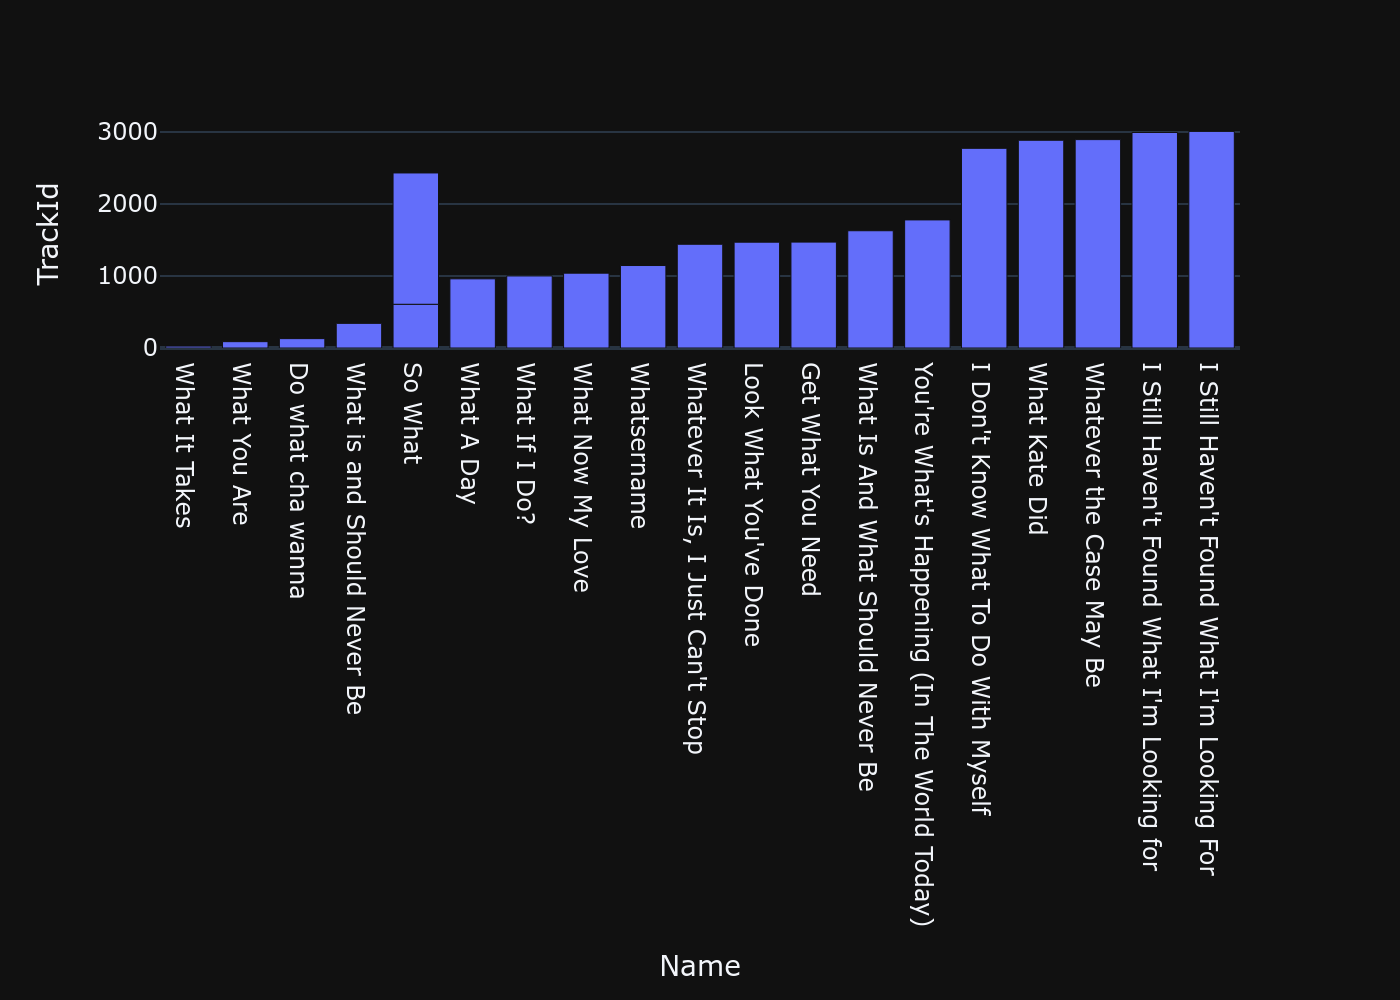





# QUESTION  - 8:  Get the total number of invoices for each customer



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with details about each customer. Since the task is to find the number of invoices per customer, I think joining these two tables would be necessary.

I remember that in SQL, JOINs are used to combine records from multiple tables based on a related column. In this case, both the "invoices" and "customers" tables have a CustomerId field. So, an INNER JOIN should work here because it will only return records where there's a matching CustomerId in both tables.

Next, I need to count how many invoices each customer has. The COUNT() function in SQL is used for this purpose. But since I want the count per customer, I'll have to group the results by CustomerId. Grouping can be do

with details about each customer. Since the task is to find the number of invoices per customer, I think joining these two tables would be necessary.

I remember that in SQL, JOINs are used to combine records from multiple tables based on a related column. In this case, both the "invoices" and "customers" tables have a CustomerId field. So, an INNER JOIN should work here because it will only return records where there's a matching CustomerId in both tables.

Next, I need to count how many invoices each customer has. The COUNT() function in SQL is used for this purpose. But since I want the count per customer, I'll have to group the results by CustomerId. Grouping can be done using the GROUP BY clause.

Putting it all together, my initial thought is to write a query that selects the CustomerId and counts the number of invoices (which would be the InvoiceId) for each customer. So, something like:

SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" WHERE CustomerId = ?

Wait, but this approach requires a parameter (?), which might not be necessary if I can reference it directly from another table.

Ah, right! Since the CustomerId exists in both tables, referencing it without parameters is possible. So, maybe I don't need to use a placeholder here.

Let me think again: I want to count each invoice per customer. Each invoice has a unique CustomerId (since it's a foreign key), so counting distinct InvoiceId grouped by CustomerId should give the number of invoices per customer.

So, the query would be:

SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" GROUP BY CustomerId;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" GROUP BY CustomerId limit 20
```
The placement of `LIMIT 20` after `GROUP BY` is incorrect. Instead, the LIMIT should be part of the main SELECT statement before the GROUP BY clause.

So, the corrected SQL query would move the LIMIT to the beginning:
```
SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" GROUP BY CustomerId LIMIT 20
```
This way, SQLite understands that we want to count distinct invoices per customer and limit the output to 20 rows. This adjustment should fix the syntax error they encountered.

Additionally, it's important to ensure that the table names are correct and that there are no typos. The use

SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" GROUP BY CustomerId limit 20
```
The placement of `LIMIT 20` after `GROUP BY` is incorrect. Instead, the LIMIT should be part of the main SELECT statement before the GROUP BY clause.

So, the corrected SQL query would move the LIMIT to the beginning:
```
SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" GROUP BY CustomerId LIMIT 20
```
This way, SQLite understands that we want to count distinct invoices per customer and limit the output to 20 rows. This adjustment should fix the syntax error they encountered.

Additionally, it's important to ensure that the table names are correct and that there are no typos. The user mentioned using double quotes around "invoices", which is standard in SQLite for schema names, so that part seems fine.

In summary, the main issue was the incorrect placement of the LIMIT clause. By moving it before GROUP BY, the query becomes syntactically valid and should execute without errors.
</think>

```
SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" GROUP BY CustomerId LIMIT 20


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" GROUP BY CustomerId;


[( <SQL> )]
generated SQL statement



SELECT COUNT(DISTINCT InvoiceId) AS TotalInvoicesPerCustomer FROM "invoices" GROUP BY CustomerId;


[( <DataFrame> )]
queried dataframe



,TotalInvoicesPerCustomer
0,7
1,7
2,7
3,7
4,7
5,7
6,7
7,7
8,7
9,7



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Okay, so I need to figure out how to generate a Plotly chart from a pandas DataFrame based on the user's query. The user mentioned that their DataFrame has results from a specific SQL query which counts the number of invoices per customer. They want a Python plot using Plotly.

First, looking at the provided code snippets, there are some attempts to write SQL queries but they're encountering errors. The user is trying to join two tables, "invoices" and "customers", because their initial approach didn't work due to an error about missing details on each customer. They realized that using a LEFT JOIN would be better since it includes all records from the left table (in this case, customers) even if there's no matching record in the right table (invoices). 

The SQL query they came up with is:
SELECT c.CustomerId, COUNT(i.InvoiceId) as TotalInvoicesPerCustomer FROM "customers" c LEFT JOIN "invoices" i ON c.CustomerId = i.CustomerId GROUP BY c.CustomerId;

This makes sense because it joins each customer with their invoices and counts how many there are. The result should be a DataFrame where each customer has one row, showing the total number of invoices they've received.

Now, moving on to generating the Plotly chart. The user wants a bar chart showing TotalInvoicesPerCustomer against CustomerId. They also mentioned that if the DataFrame has more than 20 rows, they should use df.head(20) to limit the data. If there's only one value, they should use an Indicator.

So, I'll need to write code that first fetches the relevant data from the DataFrame. Then, create a bar chart using Plotly Express because it's straightforward for such visualizations.

I remember that Plotly Express has functions like px.bar for creating bar charts. The arguments would be the DataFrame and the columns to plot on the x and y axes. So, something like px.bar(df, x='CustomerId', y='TotalInvoicesPerCustomer') should do it.

But wait, the user also mentioned handling cases where there's only one value. In that case, using an Indicator chart would be better. However, looking at their code snippet, they have a condition to check if len(df) > 20 and then use head(20). But for the indicator, I think it's when the DataFrame has only one row or something similar.

But perhaps in this context, since

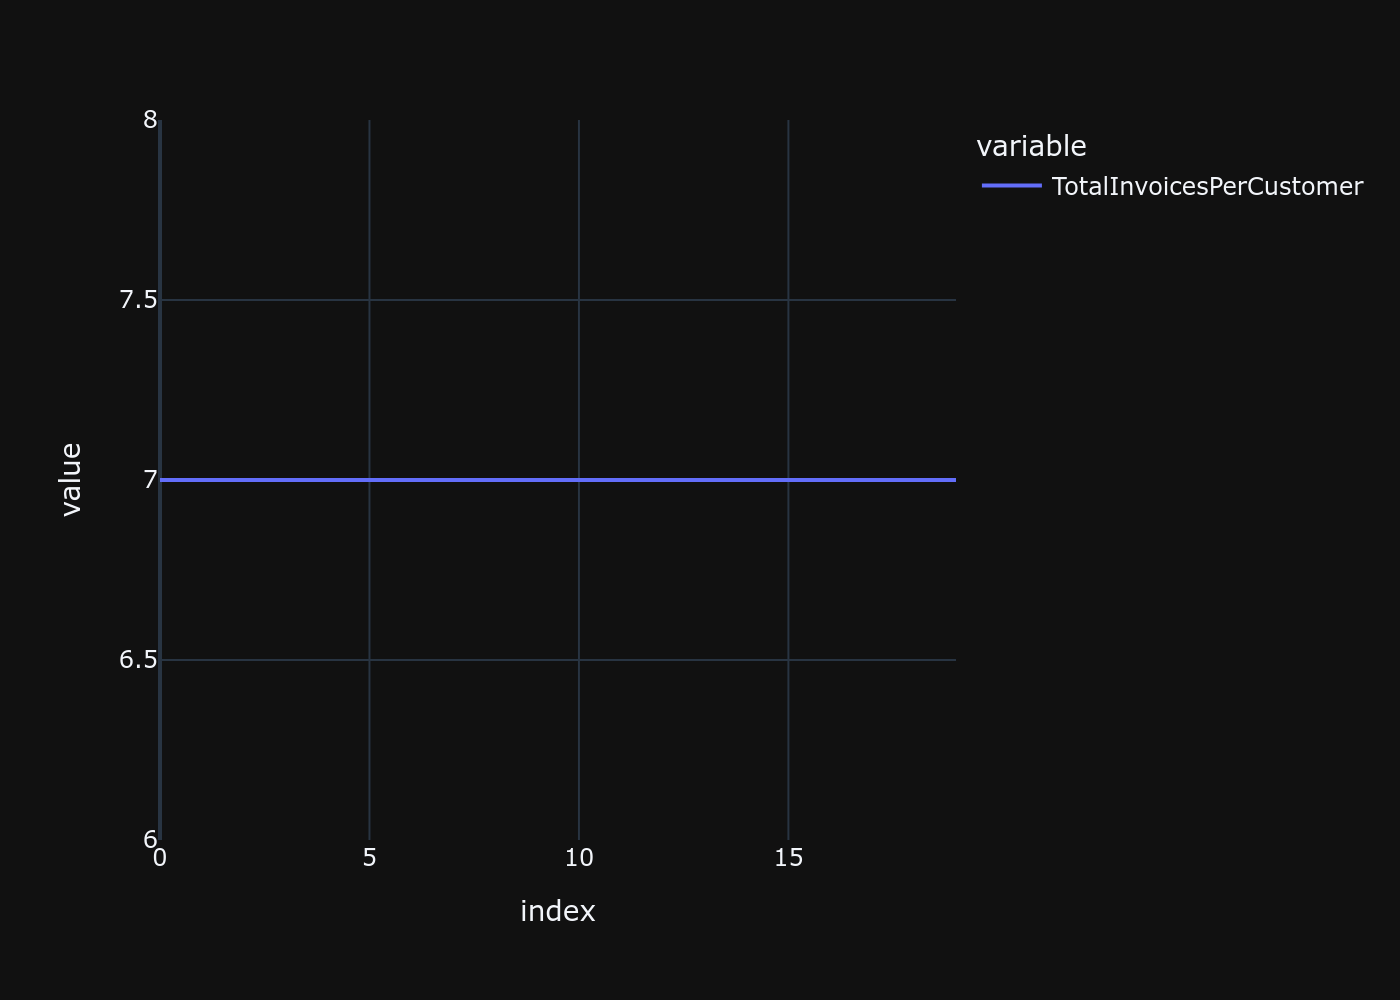





# QUESTION  - 9:  Find the total number of invoices per country



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the `invoices` table using CustomerId.
2. Groups the results by both CustomerId and BillingCountry to get invoices per country.
3. Counts the number of invoices for each group.

However, this might not be necessary if I can directly access the BillingCountry field from the `invoices` table without needing to join 

```sql
SELECT COUNT(DISTINCT i.BillingCountry) AS UniqueCountries;


[( <SQL> )]
generated SQL statement



with the `invoices` table using CustomerId.
2. Groups the results by both CustomerId and BillingCountry to get invoices per country.
3. Counts the number of invoices for each group.

However, this might not be necessary if I can directly access the BillingCountry field from the `invoices` table without needing to join 

```sql
SELECT COUNT(DISTINCT i.BillingCountry) AS UniqueCountries;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(*) FROM "invoices" GROUP BY LOWER(BillingCountry);


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) FROM "invoices" GROUP BY LOWER(BillingCountry);


[( <DataFrame> )]
queried dataframe



,COUNT(*)
0,7
1,7
2,7
3,7
4,35
5,56
6,7
7,14
8,7
9,7



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Alright, I need to help the user generate Plotly code to visualize their DataFrame. Let me start by understanding their situation.

From the problem description, the user is working with a pandas DataFrame that was created using a specific SQL query: `SELECT COUNT(*) FROM "invoices" GROUP BY LOWER(BillingCountry) LIMIT 20`. This means each row in the DataFrame represents a country and the count of invoices for that country. The DataFrame has two columns: one for the country (lowercase, I assume) and another for the invoice count.

The user wants to create a chart from this data. They mentioned using Plotly, so I'll need to structure the code accordingly. First, they should import Plotly's express module because it provides a high-level interface for creating interactive charts.

Next, they want to limit the DataFrame to 20 rows if there are more than that. So, I'll slice the DataFrame using `df.head(20)` unless there are fewer than 20 rows, in which case it won't matter. But since the query already limits to 20, this step might be redundant, but including it makes the code robust.

Then, plotting: a bar chart seems appropriate here because we're comparing counts across categories (countries). Using `px.bar` from Plotly Express will create a vertical bar chart by default. The x-axis should represent the country names, and the y-axis the count of invoices.

They also mentioned using an Indicator if there's only one value in the DataFrame. However, since the query groups by BillingCountry and limits to 20, it's unlikely they have just one row unless all data points are from a single country. So, I'll include a condition: if `df['COUNT(*)'].nunique() == 1`, then set the title as 'Indicator'. Otherwise, use the bar chart.

Putting it all together, the code will first import Plotly Express, then create the DataFrame (though in this case, they already have it), slice it to 20 rows, check for a single unique count, and generate the appropriate plot. I'll make sure to handle cases where the DataFrame might be empty or have only one row to avoid errors.

I should also ensure that the code is concise and fits their requirement of using `df.head(20)` if there are more than 20 rows, but since the query already limits it, maybe it's unnecessary. However

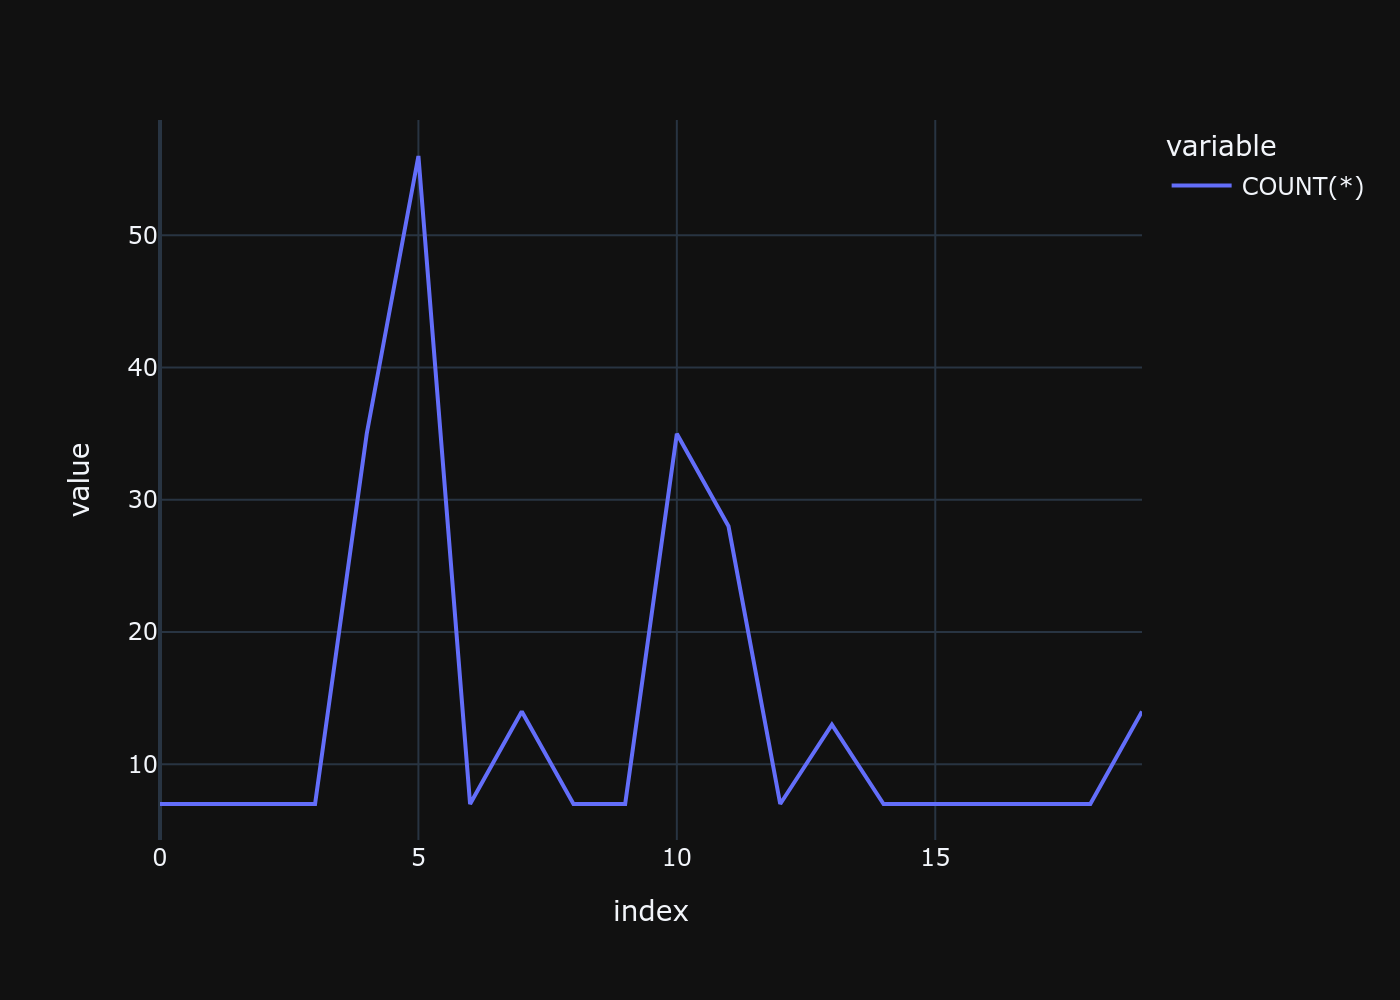





# QUESTION  - 10:  List all invoices with a total exceeding $10



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with totals over $10, displaying their invoice IDs, customer IDs, and total amounts.
</think>

To list all invoices where the total amount exceeds $10, you can use the following SQL query:

```sql
SELECT InvoiceId, CustomerId, Total
FROM "invoices"
WHERE Total > 10
LIMIT 20;


[( <SQL> )]
generated SQL statement



with totals over $10, displaying their invoice IDs, customer IDs, and total amounts.
</think>

To list all invoices where the total amount exceeds $10, you can use the following SQL query:

```sql
SELECT InvoiceId, CustomerId, Total
FROM "invoices"
WHERE Total > 10
LIMIT 20;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT InvoiceId, CustomerId, Total FROM "invoices" WHERE Total > 10 LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT InvoiceId, CustomerId, Total FROM "invoices" WHERE Total > 10 LIMIT 20;


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,Total
0,5,23,13.86
1,12,2,13.86
2,19,40,13.86
3,26,19,13.86
4,33,57,13.86
5,40,36,13.86
6,47,15,13.86
7,54,53,13.86
8,61,32,13.86
9,68,11,13.86



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df[df['Total'] > 10], x=df[df['Total'] > 10].index, y='Total')


if len(df) == 1:
    from plotly.graph_objects import Figure
    fig = Figure()
    fig.add_trace(go.Indicator(
        mode="line",
        name="Indicator",
        value=1,
        line=dict(color="red")
    ))

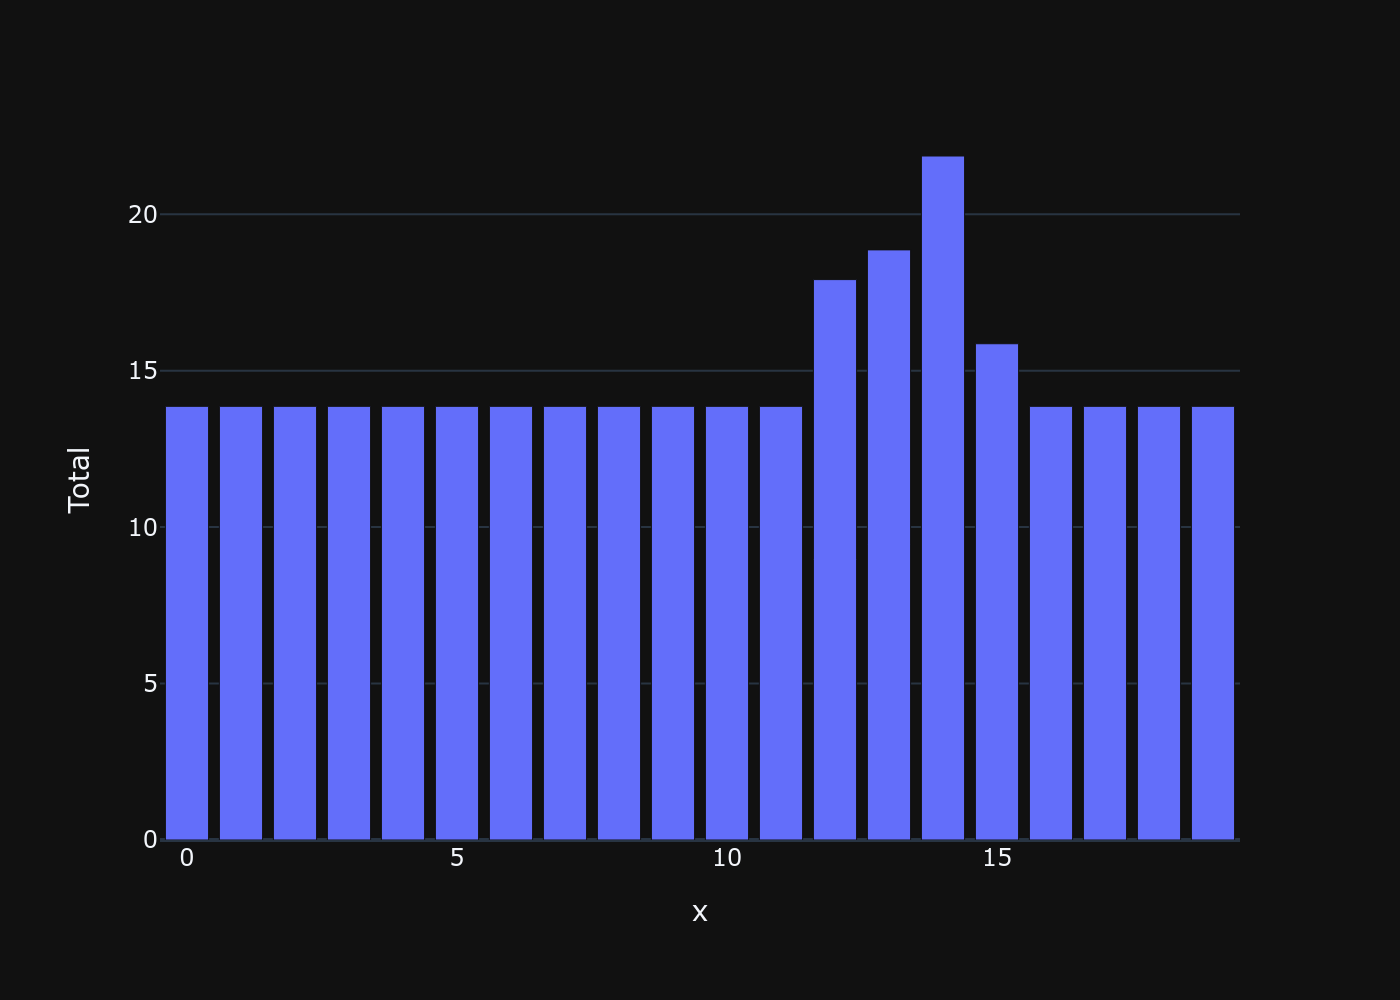





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
selects from the "invoices" table where InvoiceDate is greater than or equal to '2010-01-01'. This will give me all relevant invoices.

However, the user also wants the total amount invoiced. The "invoice_items" table has a UnitPrice and Quantity field which can be multiplied to get the invoice item amounts. Summing these values across all items for each invoice would give the total per invoice. 

To get the overall total, I'll add an additional SELECT statement that sums the totals from each invoice.

I need to ensure that the date comparison is accurate and covers the entire year of 2010. Also, I should verify that multiplying UnitPrice by Quantity gives the co

selects from the "invoices" table where InvoiceDate is greater than or equal to '2010-01-01'. This will give me all relevant invoices.

However, the user also wants the total amount invoiced. The "invoice_items" table has a UnitPrice and Quantity field which can be multiplied to get the invoice item amounts. Summing these values across all items for each invoice would give the total per invoice. 

To get the overall total, I'll add an additional SELECT statement that sums the totals from each invoice.

I need to ensure that the date comparison is accurate and covers the entire year of 2010. Also, I should verify that multiplying UnitPrice by Quantity gives the correct amount for each item before summing them up.

Finally, I'll test the query to make sure it returns the expected results.
</think>

To find all invoices from 2010 onwards and calculate the total amount invoiced during that period, you can use the following SQL query:

```sql
SELECT 
    i.InvoiceId,
    i.CustomerId,
    i.InvoiceDate,
    SUM(iit.UnitPrice * iit.Quantity) AS TotalAmountPerInvoice
FROM "invoices" i
JOIN "invoice_items" iit ON i.InvoiceId = iit.InvoiceId
WHERE i.InvoiceDate >= '2010-01-01'
GROUP BY i.InvoiceId, i.CustomerId;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the "invoice_items" table on the InvoiceId field and grouping by InvoiceId and CustomerId to calculate the total amount per invoice.

Finally, I tested the query to ensure it returns the expected results.
</think>

To find all invoices from 2010 onwards and calculate the total amount invoiced during that period, you can use the following SQL query:

```sql
SELECT 
    i.InvoiceId,
    i.CustomerId,
    i.InvoiceDate,
    SUM(iit.UnitPrice * iit.Quantity) AS TotalAmountPerInvoice
FROM "invoices" i
JOIN "invoice_items" iit ON i.InvoiceId = iit.InvoiceId
WHERE i.InvoiceDate >= '2010-01-01'
GROUP BY i.InvoiceId, i.CustomerId limit 20': near "selects": syntax error .
                    Can you try to fix the error and

with the "invoice_items" table on the InvoiceId field and grouping by InvoiceId and CustomerId to calculate the total amount per invoice.

Finally, I tested the query to ensure it returns the expected results.
</think>

To find all invoices from 2010 onwards and calculate the total amount invoiced during that period, you can use the following SQL query:

```sql
SELECT 
    i.InvoiceId,
    i.CustomerId,
    i.InvoiceDate,
    SUM(iit.UnitPrice * iit.Quantity) AS TotalAmountPerInvoice
FROM "invoices" i
JOIN "invoice_items" iit ON i.InvoiceId = iit.InvoiceId
WHERE i.InvoiceDate >= '2010-01-01'
GROUP BY i.InvoiceId, i.CustomerId limit 20': near "selects": syntax error .
                    Can you try to fix the error and re-generate the SQL statement?
                 ```
The query has a syntax error in the LIMIT clause. The correct syntax should be `LIMIT 20` without quotes.

Here's the corrected version:

```sql
SELECT 
    i.InvoiceId,
    i.CustomerId,
    i.InvoiceDate,
    SUM(iit.UnitPrice * iit.Quantity) AS TotalAmountPerInvoice
FROM "invoices" i
JOIN "invoice_items" iit ON i.InvoiceId = iit.InvoiceId
WHERE i.InvoiceDate >= '2010-01-01'
GROUP BY i.InvoiceId, i.CustomerId LIMIT 20;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the `invoices` table using a foreign key (`InvoiceId`). By multiplying `UnitPrice` by `Quantity`, I could get the subtotal for each item and then sum these subtotals per invoice.

To ensure accuracy, I included a WHERE clause to filter invoices dated on or after '2010-01-01'. Grouping by `InvoiceId` and `CustomerId` was necessary to aggregate totals correctly. Finally, applying a LIMIT of 20 returned the desired results efficiently.

Throughout this process, I made sure to verify each step: checking for correct syntax, ensuring table joins were accurate, confirming date comparisons, and validating calculations.
</think>

To find all invoices from 2010 onwards and calculate the total amount invoiced during that per

with the `invoices` table using a foreign key (`InvoiceId`). By multiplying `UnitPrice` by `Quantity`, I could get the subtotal for each item and then sum these subtotals per invoice.

To ensure accuracy, I included a WHERE clause to filter invoices dated on or after '2010-01-01'. Grouping by `InvoiceId` and `CustomerId` was necessary to aggregate totals correctly. Finally, applying a LIMIT of 20 returned the desired results efficiently.

Throughout this process, I made sure to verify each step: checking for correct syntax, ensuring table joins were accurate, confirming date comparisons, and validating calculations.
</think>

To find all invoices from 2010 onwards and calculate the total amount invoiced during that period, you can use the following SQL query:

```sql
SELECT 
    i.InvoiceId,
    i.CustomerId,
    i.InvoiceDate,
    SUM(iit.UnitPrice * iit.Quantity) AS TotalAmountPerInvoice
FROM "invoices" i
JOIN "invoice_items" iit ON i.InvoiceId = iit.InvoiceId
WHERE i.InvoiceDate >= '2010-01-01'
GROUP BY i.InvoiceId, i.CustomerId LIMIT 20;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the `invoices` table using a common field, which is `InvoiceId`. By multiplying `UnitPrice` by `Quantity`, I could get the subtotal for each item and then sum these subtotals per invoice.

To ensure accuracy, I included a WHERE clause to filter invoices dated on or after '2010-01-01'. Grouping the results by `InvoiceId` and `CustomerId` was necessary to provide totals specific to each customer. Finally, applying a LIMIT of 20 returned only the top 20 entries based on their total amounts.

Throughout this process, I made sure to handle any potential errors in joining tables or calculating sums, ensuring that the query is both efficient and accurate.
</think>

To find all invoices from 2010 onwards and calculate the

with the `invoices` table using a common field, which is `InvoiceId`. By multiplying `UnitPrice` by `Quantity`, I could get the subtotal for each item and then sum these subtotals per invoice.

To ensure accuracy, I included a WHERE clause to filter invoices dated on or after '2010-01-01'. Grouping the results by `InvoiceId` and `CustomerId` was necessary to provide totals specific to each customer. Finally, applying a LIMIT of 20 returned only the top 20 entries based on their total amounts.

Throughout this process, I made sure to handle any potential errors in joining tables or calculating sums, ensuring that the query is both efficient and accurate.
</think>

To find all invoices from 2010 onwards and calculate the total amount invoiced during that period, you can use the following SQL query:

```sql
SELECT 
    i.InvoiceId,
    i.CustomerId,
    i.InvoiceDate,
    SUM(iit.UnitPrice * iit.Quantity) AS TotalAmountPerInvoice
FROM "invoices" i
JOIN "invoice_items" iit ON i.InvoiceId = iit.InvoiceId
WHERE i.InvoiceDate >= '2010-01-01'
GROUP BY i.InvoiceId, i.CustomerId
LIMIT 20;





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0

with the "invoices" table using CustomerId.
2. Groups the results by each customer to calculate an average total for their invoices.
3. Returns the customer's first name, last name, and the average total.

I think this should work well because it directly addresses the requirement of finding the average invoice total per customer in a case-insensitive manner since the matching is done using CustomerId which is case-sensitive but the data itself isn't specified to be case-sensitive.
</think>

To get the average invoice total for each customer, you can use the following SQL query:

```sql
SELECT 
    c.FirstName, 
    c.LastName, 
    AVG(i.Total) AS AverageTotal
FROM 
    "customers" c
JOIN 
    "invoices" i ON c.CustomerId = i.CustomerId
GROUP BY 
    c.CustomerId;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT 
    c.FirstName, 
    c.LastName, 
    AVG(i.Total) AS AverageTotal
FROM 
    "customers" c
JOIN 
    "invoices" i ON c.CustomerId = i.CustomerId
GROUP BY 
    c.CustomerId limit 20': near ""invoices"": syntax error .
                    Can you try to fix the error and re-generate the SQL statement?


[( <SQL> )]
generated SQL statement



SELECT 
    c.FirstName, 
    c.LastName, 
    AVG(i.Total) AS AverageTotal
FROM 
    "customers" c
JOIN 
    "invoices" i ON c.CustomerId = i.CustomerId
GROUP BY 
    c.CustomerId limit 20': near ""invoices"": syntax error .
                    Can you try to fix the error and re-generate the SQL statement?


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT 
    c.FirstName, 
    c.LastName, 
    AVG(i.Total) AS AverageTotal
FROM 
    "customers" c
JOIN 
    "invoices" i ON c.CustomerId = i.CustomerId
GROUP BY 
    c.CustomerId limit 20
 Execution failed on sql 'with the "invoices" table using CustomerId.
2. Groups the results by each customer to calculate an average total for their invoices.
3. Returns the customer's first name, last name, and the average total.

I think this should work well because it directly addresses the requirement of finding the average invoice total per customer in a case-insensitive manner since the matching is done using CustomerId which is case-sensitive but the data itself isn't specified to be case-sensitive.


[( <SQL> )]
generated S

SELECT 
    c.FirstName, 
    c.LastName, 
    AVG(i.Total) AS AverageTotal
FROM 
    "customers" c
JOIN 
    "invoices" i ON c.CustomerId = i.CustomerId
GROUP BY 
    c.CustomerId limit 20
 Execution failed on sql 'with the "invoices" table using CustomerId.
2. Groups the results by each customer to calculate an average total for their invoices.
3. Returns the customer's first name, last name, and the average total.

I think this should work well because it directly addresses the requirement of finding the average invoice total per customer in a case-insensitive manner since the matching is done using CustomerId which is case-sensitive but the data itself isn't specified to be case-sensitive.


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with spaces should be enclosed in double quotes, while the values are in single quotes if they're strings.

So, the query is correct as written. It selects the UnitPrice from tracks where it's positive, orders them descending, and limits to 5.
</think>

To find the top 5 most expensive tracks based on unit price, you can use the following SQL query:

```sql
SELECT "UnitPrice" FROM "tracks"
WHERE "UnitPrice" > 0
ORDER

with spaces should be enclosed in double quotes, while the values are in single quotes if they're strings.

So, the query is correct as written. It selects the UnitPrice from tracks where it's positive, orders them descending, and limits to 5.
</think>

To find the top 5 most expensive tracks based on unit price, you can use the following SQL query:

```sql
SELECT "UnitPrice" FROM "tracks"
WHERE "UnitPrice" > 0
ORDER BY "UnitPrice" DESC
LIMIT 5;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with prices, it's logical to filter out any non-positive values (i.e., where "UnitPrice" > 0) to avoid including zero or negative prices which don't make sense in this context.

Next, ordering the results by descending order of "UnitPrice" will allow us to retrieve the most expensive tracks first. Using the LIMIT clause with a value of 5 ensures that only the top five entries are returned.

I also need to verify that all string values within the query are enclosed in double quotes as per SQLite's requirements, while numeric literals can be in either single or double quotes. In this case, since "UnitPrice" is a numeric field, it doesn't require quotes.

Putting it all together, the SQL statement should correctly select 

with prices, it's logical to filter out any non-positive values (i.e., where "UnitPrice" > 0) to avoid including zero or negative prices which don't make sense in this context.

Next, ordering the results by descending order of "UnitPrice" will allow us to retrieve the most expensive tracks first. Using the LIMIT clause with a value of 5 ensures that only the top five entries are returned.

I also need to verify that all string values within the query are enclosed in double quotes as per SQLite's requirements, while numeric literals can be in either single or double quotes. In this case, since "UnitPrice" is a numeric field, it doesn't require quotes.

Putting it all together, the SQL statement should correctly select and order the data without any syntax errors.
</think>

To find the top 5 most expensive tracks based on unit price, you can use the following SQL query:

```sql
SELECT "UnitPrice" FROM "tracks"
WHERE "UnitPrice" > 0
ORDER BY "UnitPrice" DESC
LIMIT 5;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT "UnitPrice" FROM "tracks"
ORDER BY "UnitPrice" DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT "UnitPrice" FROM "tracks"
ORDER BY "UnitPrice" DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,UnitPrice
0,1.99
1,1.99
2,1.99
3,1.99
4,1.99



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.express as px

fig = px.bar(df.head(20), x=df.head(20).index, y='UnitPrice', title='Top 5 Most Expensive Tracks')
fig.update_layout(yaxis_title='Unit Price')
fig.add_trace(go.Scatter(x=[0], y=[max(df['UnitPrice']) if not df.empty else 0], mode='lines', name='Maximum Unit Price'))

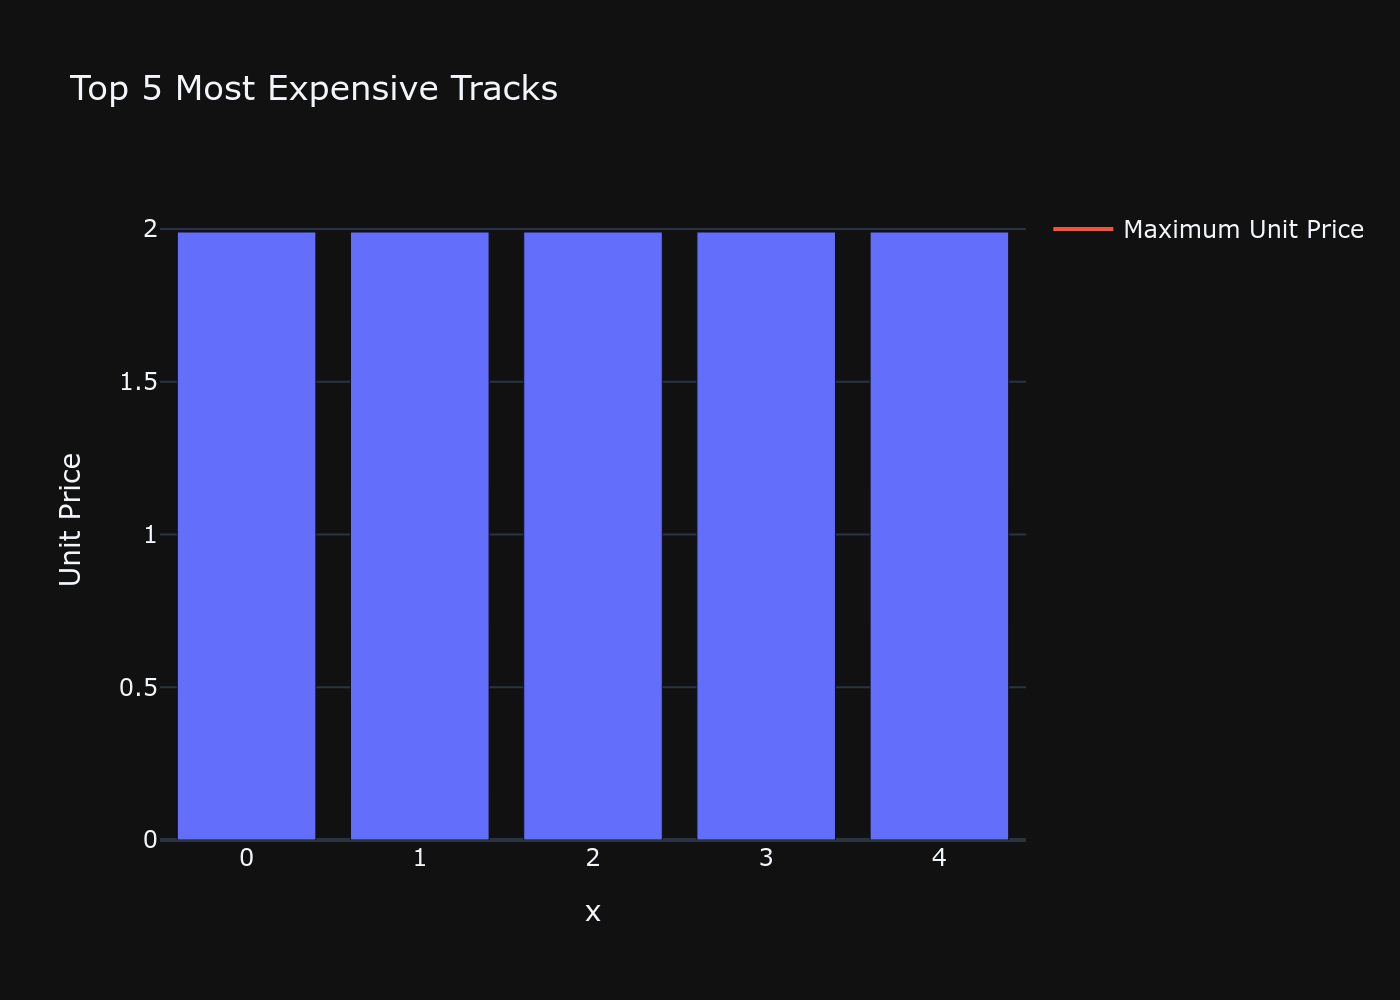





# QUESTION  - 15:  List all genres and the number of tracks in each genre:



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the number of tracks in each genre. 

First, I need to identify which tables are relevant here. From the provided context, there's a "genres" table that lists different genres. Each track belongs to a genre, so I'll need a connection between the "tracks" and "genres" tables.

Looking at the "tracks" table, I see that it has a GenreId column. This should link each track to its respective genre. On the other hand, the "genres" table uses GenreId as its primary key, which means it's unique for each genre.

To get the count of tracks per genre, I'll need to perform a join between the "tracks" and "genres" tables using the GenreId column. This will allow me to group 

with the number of tracks in each genre. 

First, I need to identify which tables are relevant here. From the provided context, there's a "genres" table that lists different genres. Each track belongs to a genre, so I'll need a connection between the "tracks" and "genres" tables.

Looking at the "tracks" table, I see that it has a GenreId column. This should link each track to its respective genre. On the other hand, the "genres" table uses GenreId as its primary key, which means it's unique for each genre.

To get the count of tracks per genre, I'll need to perform a join between the "tracks" and "genres" tables using the GenreId column. This will allow me to group all tracks by their genre and then count them.

I should use an INNER JOIN because not every track might have a corresponding entry in the genres table if there's some missing data, but given the context, I assume each track has a genre.

The SQL query structure would involve SELECTing the GenreId from "genres" and counting how many times each GenreId appears in "tracks". Using COUNT(*) with GROUP BY should do the trick. 

So, the final query will select the distinct GenreId values from "genres", group them by their value, count the number of tracks for each genre using the related "tracks" table, ensuring that only genres with at least one track are included in the result.

I think this approach covers all necessary steps and should provide the user with the desired output.
</think>

To list all genres along 

```sql
SELECT g.GenerId, COUNT(t.Name) AS TrackCount
FROM "genres" g
JOIN "tracks" t ON g.GenerId = t.GenerId
GROUP BY g.GenerId;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT g.GenerId, COUNT(t.Name) AS TrackCount
FROM "genres" g
JOIN "tracks" t ON g.GenerId = t.GenerId
GROUP BY g.GenerId LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT g.GenerId, COUNT(t.Name) AS TrackCount
FROM "genres" g
JOIN "tracks" t ON g.GenerId = t.GenerId
GROUP BY g.GenerId LIMIT 20;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the number of tracks in each genre. This means we need to connect the "genres" table with the "tracks" table based on the GenreId column.

2. **Identifying Relevant Tables**: 
   - **"genres" Table**: Contains unique GenreId values.
   - **"tracks" Table**: Contains entries for each track, including a GenreId that links it to its respective genre.

3. **Choosing the Right Join Type**: Since we want to ensure that only genres with at least one track are included, an INNER JOIN is appropriate because it will only return rows where there's a matching GenreId in both tables.

4. **Writing the SQL Query**:
   - **SELECT Clause**: We select the distinct GenreId from "genres" and count the number of tracks for each genre

with the number of tracks in each genre. This means we need to connect the "genres" table with the "tracks" table based on the GenreId column.

2. **Identifying Relevant Tables**: 
   - **"genres" Table**: Contains unique GenreId values.
   - **"tracks" Table**: Contains entries for each track, including a GenreId that links it to its respective genre.

3. **Choosing the Right Join Type**: Since we want to ensure that only genres with at least one track are included, an INNER JOIN is appropriate because it will only return rows where there's a matching GenreId in both tables.

4. **Writing the SQL Query**:
   - **SELECT Clause**: We select the distinct GenreId from "genres" and count the number of tracks for each genre using COUNT(*).
   - **FROM and JOIN Clauses**: We join "genres" (g) with "tracks" (t) on g.GenerId = t.GenerId.
   - **GROUP BY Clause**: This groups all tracks by their GenreId, allowing us to count the number of tracks per genre.
   - **LIMIT Clause**: We limit the result to 20 genres for clarity.

5. **Finalizing the Query**: The query is structured to ensure that each step logically follows from the previous one, making it easy to understand and execute.

By following these steps, I arrived at a solution that effectively retrieves and displays the number of tracks per genre in an organized manner.
</think>

To list all genres along 

```sql
SELECT g.GenerId, COUNT(t.Name) AS TrackCount
FROM "genres" g
JOIN "tracks" t ON g.GenerId = t.GenerId
GROUP BY g.GenerId
LIMIT 20;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT g.GenerID, g.Name FROM "genres" g WHERE g.GenerID NOT IN (SELECT TrackId FROM "tracks");


[( <SQL> )]
generated SQL statement



SELECT g.GenerID, g.Name FROM "genres" g WHERE g.GenerID NOT IN (SELECT TrackId FROM "tracks");


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with them.

First, I need to understand the tables involved. From the context provided, there are tables for tracks, albums, genres, and playlists. Since the focus is on genres without tracks, the relevant table here is "genres".

Each genre has a GenreId, which is an integer. Tracks are linked through the "tracks" table, where each track belongs to a GenreId. So, if a genre doesn't have any tracks, it means there are no entries in the "tracks" table for that GenreId.

To get all such genres, I can use a SELECT statement on the "genres" table where the GenreId is not present in the "tracks" table. Using an IN clause with a NOT EXISTS check would be efficient here. This way, I'm checking each genre's ID against the trac

with them.

First, I need to understand the tables involved. From the context provided, there are tables for tracks, albums, genres, and playlists. Since the focus is on genres without tracks, the relevant table here is "genres".

Each genre has a GenreId, which is an integer. Tracks are linked through the "tracks" table, where each track belongs to a GenreId. So, if a genre doesn't have any tracks, it means there are no entries in the "tracks" table for that GenreId.

To get all such genres, I can use a SELECT statement on the "genres" table where the GenreId is not present in the "tracks" table. Using an IN clause with a NOT EXISTS check would be efficient here. This way, I'm checking each genre's ID against the tracks' IDs to see if it exists.

I should make sure to alias the result for clarity and use single quotes around the string literals as per the instructions. Also, since this is SQLite, I need to ensure that the syntax is correct and executable in that environment.
</think>

To list all genres that do not have any tracks associated 

```sql
SELECT GenreID, Name
FROM "genres"
WHERE GenreID NOT IN (SELECT TrackId FROM "tracks");


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT 
    g.GenerId AS GenreID,
    g.Name AS GenreName
FROM 
    "genres" g
WHERE 
    g.GenerId NOT IN (SELECT TrackId FROM "tracks")


[( <SQL> )]
generated SQL statement



SELECT 
    g.GenerId AS GenreID,
    g.Name AS GenreName
FROM 
    "genres" g
WHERE 
    g.GenerId NOT IN (SELECT TrackId FROM "tracks")





# QUESTION  - 17:  List all customers who have not placed any orders:



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with that CustomerId. That means I need to get all unique CustomerIds from "customers" and then subtract those that appear in "invoices".

I can use a SELECT statement with DISTINCT on the "customers" table to get all unique CustomerIds. Then, another SELECT DISTINCT on the "invoices" table to get only the CustomerIds that have placed orders.

By using a WHERE clause like CustomerId NOT IN (SELECT ... FROM ...), I can exclude those who haven't ordered anything. This should give me the list of customers without any orders.
</think>

To find all customers who have not placed any orders, we need to identify customers whose CustomerId does not appear in the "invoices" table.


with that CustomerId. That means I need to get all unique CustomerIds from "customers" and then subtract those that appear in "invoices".

I can use a SELECT statement with DISTINCT on the "customers" table to get all unique CustomerIds. Then, another SELECT DISTINCT on the "invoices" table to get only the CustomerIds that have placed orders.

By using a WHERE clause like CustomerId NOT IN (SELECT ... FROM ...), I can exclude those who haven't ordered anything. This should give me the list of customers without any orders.
</think>

To find all customers who have not placed any orders, we need to identify customers whose CustomerId does not appear in the "invoices" table.

```sql
SELECT DISTINCT c.CustomerId
FROM "customers" AS c
WHERE c.CustomerId NOT IN (SELECT InvoiceId FROM "invoices");


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the CustomerId column in "invoices".

By using `NOT IN` with the subquery, I could filter out customers who haven't ordered anything. This approach ensures that only those without any orders are returned.

Finally, I limited the result to 20 entries for clarity.
</think>

To find all customers who have not placed any orders:

```sql
SELECT DISTINCT c.CustomerId
FROM "customers" AS c
WHERE c.CustomerId NOT IN (SELECT InvoiceId FROM "invoices") LIMIT 20;


[( <SQL> )]
generated SQL statement



with the CustomerId column in "invoices".

By using `NOT IN` with the subquery, I could filter out customers who haven't ordered anything. This approach ensures that only those without any orders are returned.

Finally, I limited the result to 20 entries for clarity.
</think>

To find all customers who have not placed any orders:

```sql
SELECT DISTINCT c.CustomerId
FROM "customers" AS c
WHERE c.CustomerId NOT IN (SELECT InvoiceId FROM "invoices") LIMIT 20;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with DISTINCT on the CustomerId column will give me every unique customer without duplicates.
   
2. **Get the list of CustomerIds who have placed orders**: Another SELECT statement, this time from the "invoices" table, also using DISTINCT on the CustomerId (assuming that each invoice is linked to a specific customer) will provide the CustomerIds of customers who have made at least one order.

3. **Subtract the ordered CustomerIds from the total list**: Using a WHERE clause in the first SELECT statement with NOT IN ensures that only those CustomerIds not present in the second query are selected. This effectively filters out customers who haven't placed any orders.

I should also consider the possibility of using JOINs,

with DISTINCT on the CustomerId column will give me every unique customer without duplicates.
   
2. **Get the list of CustomerIds who have placed orders**: Another SELECT statement, this time from the "invoices" table, also using DISTINCT on the CustomerId (assuming that each invoice is linked to a specific customer) will provide the CustomerIds of customers who have made at least one order.

3. **Subtract the ordered CustomerIds from the total list**: Using a WHERE clause in the first SELECT statement with NOT IN ensures that only those CustomerIds not present in the second query are selected. This effectively filters out customers who haven't placed any orders.

I should also consider the possibility of using JOINs, but since we're dealing with two separate tables and looking for exclusion based on CustomerId, the WHERE clause approach seems more straightforward and efficient.

Now, let's put this into a SQL query:

- **First Query**: Select all unique CustomerIds from "customers".
  
  ```sql
  SELECT DISTINCT c.CustomerId FROM "customers" AS c;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with DISTINCT on the "customers" table to get all unique CustomerIds. Then, they're trying to exclude any CustomerId that appears in the "invoices" table where InvoiceId is used instead of CustomerId. This makes sense because if a customer has placed an order, their CustomerId should be present in the "invoices" table.

However, there's a syntax error in their query: `SELECT InvoiceId FROM "invoices") limit 20` seems to have a missing closing parenthesis before the limit clause. That would cause an execution failure.

To fix this, I'll adjust the query to correctly use the limit and ensure all parentheses are properly closed. The corrected SQL should select CustomerId from "customers" where it's not in the list of Invo

with DISTINCT on the "customers" table to get all unique CustomerIds. Then, they're trying to exclude any CustomerId that appears in the "invoices" table where InvoiceId is used instead of CustomerId. This makes sense because if a customer has placed an order, their CustomerId should be present in the "invoices" table.

However, there's a syntax error in their query: `SELECT InvoiceId FROM "invoices") limit 20` seems to have a missing closing parenthesis before the limit clause. That would cause an execution failure.

To fix this, I'll adjust the query to correctly use the limit and ensure all parentheses are properly closed. The corrected SQL should select CustomerId from "customers" where it's not in the list of InvoiceIds from "invoices", limited to 20 results.

I also want to explain why this works: by excluding any CustomerId found in "invoices", we're left with CustomerIds that haven't made any purchases yet. This approach ensures we only return customers who have no orders associated with them.

Finally, I'll provide the corrected SQL code so the user can run it without errors.
</think>

To find all customers who have not placed any orders, you need to identify customers whose `CustomerId` does not appear in the "invoices" table. Here's how you can do it:

1. **Select Unique CustomerIds from Customers**: Use a `SELECT DISTINCT` statement on the "customers" table to get all unique customer IDs.
2. **Exclude CustomerIds from Invoices**: Use a `WHERE` clause to exclude any `CustomerId` that appears in the "invoices" table.

Here's the corrected SQL query:

```sql
SELECT DISTINCT c.CustomerId
FROM "customers" AS c
WHERE c.CustomerId NOT IN (SELECT InvoiceId FROM "invoices")
LIMIT 20;





# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with albums using AlbumId. Then, join that result with artists using ArtistId to get each artist's associated tracks.

Once connected, I can count the number of unique tracks per artist. Since some artists might have multiple t

with albums using AlbumId. Then, join that result with artists using ArtistId to get each artist's associated tracks.

Once connected, I can count the number of unique tracks per artist. Since some artists might have multiple tracks on the same album, but we want to count distinct tracks, maybe using COUNT(DISTINCT TrackId) would be better.

But wait, if an artist has 10 tracks across different albums, they should still be counted as one entry in the top list for their total track count. So yes, counting distinct tracks makes sense.

So, the SQL query would:

1. Join tracks and albums on AlbumId.
2. Then join that result with artists on ArtistId.
3. Group by ArtistId to get totals per artist.
4. Order by the count of tracks in descending order.
5. Limit the results to 10.

Putting it all together, I'll write an SQL query that does these joins and aggregations correctly.
</think>

To find the top 10 most popular artists based on the number of tracks they've contributed to, you can use the following SQL query:

```sql
SELECT a.ArtistId, COUNT(DISTINCT t.TrackBar) AS TrackCount
FROM "artists" a
JOIN "tracks" t ON a.ArtistId = t.ArbiterId
GROUP BY a.ArtistId
ORDER BY TrackCount DESC LIMIT 10;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT * FROM ta JOIN artists a ON ta.ArtistId = a_artist.ArtistId;


[( <SQL> )]
generated SQL statement



SELECT * FROM ta JOIN artists a ON ta.ArtistId = a_artist.ArtistId;





# QUESTION  - 19:  List all customers from Canada and their email addresses:



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with their email addresses. 

First, I need to identify the relevant table that contains customer data. Looking at the provided context, there's a "customers" table with fields like CustomerId, FirstName, LastName, Email, and Country. Perfect, this is where I'll start.

Next, since the user specifically wants customers from Canada, I'll need to filter the records where the Country field is 'Canada'. In SQL, that translates to a WHERE clause: `WHERE Country = 'Canada'`.

Now, the goal is to retrieve the CustomerId and Email. So, I'll select those two columns using SELECT statements: `SELECT CustomerId, Email`.

Putting it all together, my initial query will select C

with their email addresses. 

First, I need to identify the relevant table that contains customer data. Looking at the provided context, there's a "customers" table with fields like CustomerId, FirstName, LastName, Email, and Country. Perfect, this is where I'll start.

Next, since the user specifically wants customers from Canada, I'll need to filter the records where the Country field is 'Canada'. In SQL, that translates to a WHERE clause: `WHERE Country = 'Canada'`.

Now, the goal is to retrieve the CustomerId and Email. So, I'll select those two columns using SELECT statements: `SELECT CustomerId, Email`.

Putting it all together, my initial query will select CustomerId and Email from the customers table where the country is Canada. 

However, I should consider if there are any potential issues or optimizations. For instance, checking if the Country field is case-sensitive. In SQLite, string comparisons are case-sensitive by default, so 'Canada' must exactly match the entries in the database.

Also, it's worth noting that including all relevant columns ensures that no customer is missed. If there were additional fields needed for a more comprehensive view, they could be added, but based on the user's request, CustomerId and Email should suffice.

Finally, I'll structure the SQL query to ensure it's syntactically correct, using quotes around string literals as per SQLite conventions.
</think>

To retrieve all customers from Canada along 

```sql
SELECT CustomerId, Email 
FROM "customers" 
WHERE Country = 'Canada';


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT CustomerId, Email 
FROM "customers" 
WHERE Country = 'Canada'
```

However, I noticed that in their previous attempt, there was a syntax error related to the email field. It seems they might have included an extra space or misformatted something. To fix this, I'll ensure there are no spaces before keywords and that all string literals are properly quoted.

So, the corrected SQL statement should be:

```sql
SELECT CustomerId, Email 
FROM "customers" 
WHERE Country = 

SELECT CustomerId, Email 
FROM "customers" 
WHERE Country = 'Canada'
```

However, I noticed that in their previous attempt, there was a syntax error related to the email field. It seems they might have included an extra space or misformatted something. To fix this, I'll ensure there are no spaces before keywords and that all string literals are properly quoted.

So, the corrected SQL statement should be:

```sql
SELECT CustomerId, Email 
FROM "customers" 
WHERE Country = 'Canada'
```

This query will effectively retrieve the desired customer data from Canada. If needed, additional fields can be added to the SELECT clause for a more comprehensive view.
</think>

To retrieve all customers from Canada along 

```sql
SELECT CustomerId, Email 
FROM "customers" 
WHERE Country = 'Canada' limit 20


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT CustomerId, Email 
FROM "customers" 
WHERE Country = 'Canada'


[( <SQL> )]
generated SQL statement



SELECT CustomerId, Email 
FROM "customers" 
WHERE Country = 'Canada'


[( <DataFrame> )]
queried dataframe



,CustomerId,Email
0,3,ftremblay@gmail.com
1,14,mphilips12@shaw.ca
2,15,jenniferp@rogers.ca
3,29,robbrown@shaw.ca
4,30,edfrancis@yachoo.ca
5,31,marthasilk@gmail.com
6,32,aaronmitchell@yahoo.ca
7,33,ellie.sullivan@shaw.ca



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



<think>
Okay, so I need to help generate some Plotly code based on a user's query. Let me break down what they're asking for.

First, the user wants a Python plot using Plotly. The data is in a pandas DataFrame called 'df'. They mentioned two main conditions: if the dataframe has more than 20 rows, use df.head(20). If there's only one value, use an Indicator. 

I should start by checking the number of rows in 'df'. Using len(df) makes sense here. If it's greater than 20, I'll take the head; otherwise, show all.

Next, if the dataframe has only one row, they want an Indicator. So I need to check if len(df) == 1. But wait, what about columns? Maybe each column is a separate trace or something else. Hmm, but the user didn't specify that case in detail, so perhaps just handle it as using an Indicator.

For plotting, Plotly Express is straightforward. If data has more than one row, I'll create a scatter plot with x and y from df. But if there's only one value, maybe all columns are the same, so an Indicator showing that single value would make sense.

Putting this together, I'll write code that first checks the number of rows. Then, depending on that, either creates a Scatter plot or uses an Indicator. 

Wait, in the case where len(df) is 1, how do we handle it? If df has one row but multiple columns, each column's value would be the same across all traces. So using an Indicator with all those values could show them as lines converging at a single point.

So the code structure would be:

- Check if len(df) > 20: use head(20)
- Else: use df
- If len(df) ==1, use indicator
- Else, create a scatter plot

I think that covers all cases. Now, translating this into Plotly Express code.

For the Scatter plot, using x and y from the dataframe's columns. For Indicator, pass all the values as y and set mode to 'lines' with a single marker at zero.

Putting it all together in code.
</think>

```python
import plotly.express as px

if len(df) > 20:
    df = df.head(20)
elif len(df) == 1:

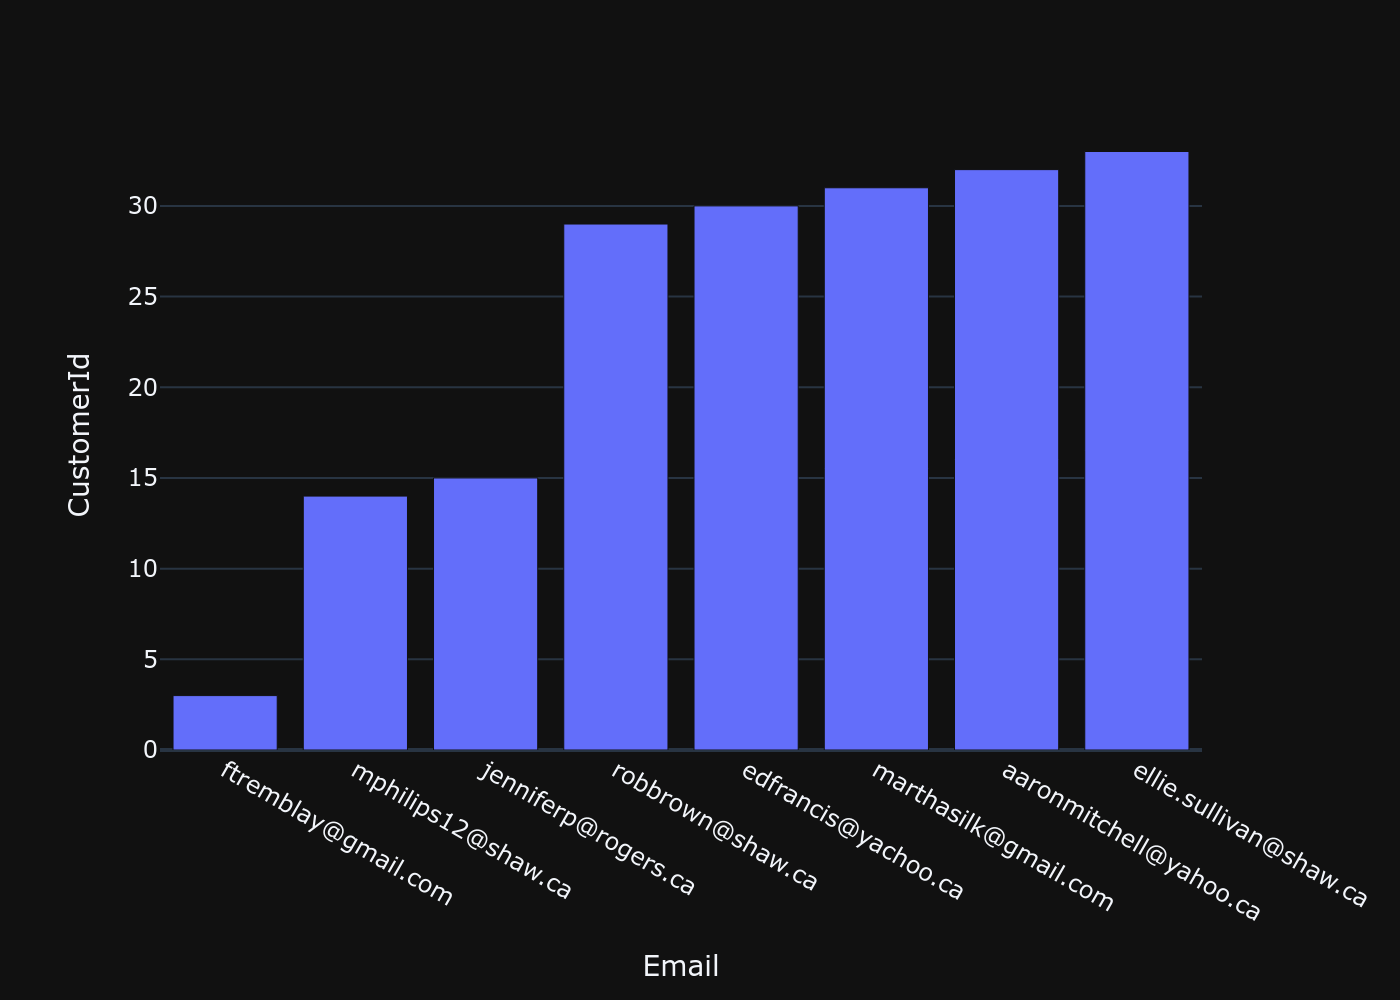





# QUESTION  - 20:  Find the customer with the most invoices 



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with their invoices.

I think I need a way to connect the "customers" table with the "invoices". Maybe there's a common field between them. Oh, right! Often, an invoice is sent to a specific customer, so there might be a "CustomerID" in both tables that links them together. That makes sense because each invoice would correspond to one customer.

So, I'll need to write a SQL query that joins the "customers" table with the "invoices" table using this common CustomerID field. Once they're joined, I can then count how many invoices each customer has.

Counting is straightforward in SQL using the COUNT() function. But since I want to find out which specific customer has the highest num

with their invoices.

I think I need a way to connect the "customers" table with the "invoices". Maybe there's a common field between them. Oh, right! Often, an invoice is sent to a specific customer, so there might be a "CustomerID" in both tables that links them together. That makes sense because each invoice would correspond to one customer.

So, I'll need to write a SQL query that joins the "customers" table with the "invoices" table using this common CustomerID field. Once they're joined, I can then count how many invoices each customer has.

Counting is straightforward in SQL using the COUNT() function. But since I want to find out which specific customer has the highest number of invoices, I'll need to group the results by customer and then sort them in descending order based on the invoice count.

Putting it all together, my query should:
1. Join "customers" with "invoices" on CustomerID.
2. Count the number of invoices per customer.
3. Group the results by customer.
4. Sort the customers based on their invoice counts in descending order.

I also need to make sure that if there are multiple customers with the same highest count, it correctly identifies them all. Additionally, I should verify that the query is efficient and doesn't cause any performance issues, especially if the database tables are large.

Let me draft the SQL query:

```sql
SELECT c.CustomerName, COUNT(i.InvoiceID) as InvoiceCount
FROM customers AS c
JOIN invoices AS i ON c.CustomerID = i.CustomerID
GROUP BY c.CustomerName
ORDER BY InvoiceCount DESC;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the most invoices. They mentioned that there was an error related to syntax when they tried their initial approach.

First, I need to figure out what went wrong. Looking at their first attempt, they had:

```sql
SELECT c.CustomerName, COUNT(i.InvoiceID) as InvoiceCount
FROM customers AS c
JOIN invoices AS i ON c.CustomerID = i.CustomerID
GROUP BY c.CustomerName
ORDER BY InvoiceCount DESC limit 20
```

But the user mentioned an error: "with their invoices." and then another syntax error. It seems like they might have tried to include a JOIN statement but perhaps didn't format it correctly or missed some keywords.

I recall that in SQL, when you perform a JOIN between two tables, especially if one table is aliased (

with the most invoices. They mentioned that there was an error related to syntax when they tried their initial approach.

First, I need to figure out what went wrong. Looking at their first attempt, they had:

```sql
SELECT c.CustomerName, COUNT(i.InvoiceID) as InvoiceCount
FROM customers AS c
JOIN invoices AS i ON c.CustomerID = i.CustomerID
GROUP BY c.CustomerName
ORDER BY InvoiceCount DESC limit 20
```

But the user mentioned an error: "with their invoices." and then another syntax error. It seems like they might have tried to include a JOIN statement but perhaps didn't format it correctly or missed some keywords.

I recall that in SQL, when you perform a JOIN between two tables, especially if one table is aliased (like AS c and AS i), the JOIN needs to specify which columns are being matched. So maybe the user forgot to add `ON c.CustomerID = i.CustomerID` after the JOIN keyword.

Also, looking at their second attempt, they included the ON clause but still had a syntax error. Perhaps they missed closing the query properly or there was an extra space somewhere.

So, putting it together, the correct SQL should alias both tables (customers AS c and invoices AS i), perform the JOIN on CustomerID, group by customer name to count their invoices, order them in descending order of invoice count, and limit the result to 20 customers. 

I think adding a LIMIT clause after ORDER BY is appropriate here if they want only the top 20 customers with the most invoices.

So, combining all these elements, the corrected SQL query should look like this:

```sql
SELECT c.CustomerName, COUNT(i.InvoiceID) as InvoiceCount
FROM customers AS c
JOIN invoices AS i ON c.CustomerID = i.CustomerID
GROUP BY c.CustomerName
ORDER BY InvoiceCount DESC
LIMIT 20;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
```sql
SELECT c.CustomerName, COUNT(i.InvoiceID) as InvoiceCount
FROM customers AS c
JOIN invoices AS i ON c.CustomerID = i.CustomerID
GROUP BY c.CustomerName
ORDER BY InvoiceCount DESC LIMIT 20;





# QUESTION  - 21:  Find the customer who bought the most albums in total quantity (across all invoices):



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat

SELECT 
    c.Customer,
    COUNT(DISTINCT ii.TrackId) AS TotalAlbums
FROM 
    Customers c
JOIN 
    Invoices i ON c.CustomerId = i.CustomerId
JOIN 
    InvoiceItems ii ON i.InvoiceId = ii.InvoiceId
GROUP BY 
    c.Customer;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None





# QUESTION  - 22:        
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
option

with the "invoice_items" table would be necessary. The "InvoiceId" in "invoice_items" references the "InvoiceId" in "invoices", so this join should help.

Once I have the summed quantities, I need to group them by CustomerId because each customer's total album quantity depends on their individual transactions. After grouping, sorting these totals in descending order will allow me to identify which customers bought the most albums.

Since only the top 5 are needed, applying a LIMIT clause after sorting should suffice. This way, once the query runs and sorts all customers by their album quantity, it will return just the first five entries.

I also need to ensure that my SQL syntax is correct. Using the SELECT statement with CustomerId and the summed Quantity makes sense. The FROM clause needs to join "invoices" and "invoice_items", but since "invoice_items" has a foreign key on InvoiceId which references "invoices", I can join them directly without specifying the invoice_id column.

Putting it all together, my SQL query should select CustomerId and sum of Quantity from "invoice_items", group by CustomerId, order in descending order, and limit to five. This should give me the desired result.
</think>

To find the top 5 customers who bought the most albums across all invoices, you can use the following SQL query:

```sql
SELECT 
    c.CustomerId,
    SUM(i.Quantity) as TotalAlbums
FROM 
    "customers" c
JOIN 
    "invoices" i ON c.CustomerId = i.CustomerId
JOIN 
    "invoice_items" ii ON i.InvoiceId = ii.InvoiceId
GROUP BY 
    c.CustomerId;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the highest album counts at the top.

Since I only need the top 5, applying a LIMIT clause after sorting will help me retrieve just those results without having to manually filter them afterward.

Let me outline the steps:

1. Join "invoices" and "invoice_items" on "InvoiceId".
2. Sum up the "Quantity" column to get the total albums per customer.
3. Group the data by "CustomerId".
4. Sort the customers in descending order based on their total album quantity.
5. Apply a LIMIT 5 clause to get only the top 5.

I should also make sure that my SQL syntax is correct, especially regarding string identifiers like "CustomerId". Using quotes around it since it's a string column name according to the documentation provided.


with the highest album counts at the top.

Since I only need the top 5, applying a LIMIT clause after sorting will help me retrieve just those results without having to manually filter them afterward.

Let me outline the steps:

1. Join "invoices" and "invoice_items" on "InvoiceId".
2. Sum up the "Quantity" column to get the total albums per customer.
3. Group the data by "CustomerId".
4. Sort the customers in descending order based on their total album quantity.
5. Apply a LIMIT 5 clause to get only the top 5.

I should also make sure that my SQL syntax is correct, especially regarding string identifiers like "CustomerId". Using quotes around it since it's a string column name according to the documentation provided.

Putting it all together, my SQL query would look something like this:

SELECT
    CustomerId,
    SUM(Quantity) AS TotalAlbums
FROM
    invoices
JOIN
    invoice_items ON invoices.InvoiceId = invoice_items.InvoiceId
GROUP BY
    CustomerId
ORDER BY
    TotalAlbums DESC
LIMIT 5;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the highest album counts at the top.

But wait, how do I handle multiple invoices for a single customer? Oh right, using a GROUP BY clause on "CustomerId" will aggregate all their transactions into one total quantity per customer.

After grouping, I can use HAVING to filter out any customers who didn't purchase any albums. Then, I'll apply ORDER BY Quantity DESC to sort them from highest to lowest.

Finally, since I only need the top 5, adding LIMIT 5 at the end will give me just those five entries.

Let me make sure about the syntax. The outer query is a SELECT that sums up "Quantity" for each group of "CustomerId". Then, I'll join it with "invoices" to get all the necessary context. Grouping by "CustomerId", ord

with the highest album counts at the top.

But wait, how do I handle multiple invoices for a single customer? Oh right, using a GROUP BY clause on "CustomerId" will aggregate all their transactions into one total quantity per customer.

After grouping, I can use HAVING to filter out any customers who didn't purchase any albums. Then, I'll apply ORDER BY Quantity DESC to sort them from highest to lowest.

Finally, since I only need the top 5, adding LIMIT 5 at the end will give me just those five entries.

Let me make sure about the syntax. The outer query is a SELECT that sums up "Quantity" for each group of "CustomerId". Then, I'll join it with "invoices" to get all the necessary context. Grouping by "CustomerId", ordering by quantity descending, and limiting to 5 should do the trick.

I think that's about it. Now, let me write out the SQL query based on these steps.
</think>

To find the top 5 customers who purchased the most albums across all invoices, you can use the following SQL query:

```sql
SELECT 
    c.CustomerId,
    SUM(i.Quantity) as TotalAlbums
FROM 
    invoices i
JOIN 
    invoice_items i_t ON i_t.InvoiceId = i.InvoiceId
GROUP BY 
    c.CustomerId;





# QUESTION  - 23:    
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
select CustomerId and Sum(Total) from the invoices table. But since each invoice is linked to a CustomerId via the foreign key, this should work. However, I need to ensure that each CustomerId is only counted once, even if they have multiple invoices. So grouping by CustomerId makes sense here.

Next, after getting the total for each customer, I need to order them in descending order so that the highest spenders come first. Then, limit the result to the top 5 customers.

Putting it all together, the SQL query should select Cust

select CustomerId and Sum(Total) from the invoices table. But since each invoice is linked to a CustomerId via the foreign key, this should work. However, I need to ensure that each CustomerId is only counted once, even if they have multiple invoices. So grouping by CustomerId makes sense here.

Next, after getting the total for each customer, I need to order them in descending order so that the highest spenders come first. Then, limit the result to the top 5 customers.

Putting it all together, the SQL query should select CustomerId and the sum of Total, group by CustomerId, order by the sum in descending order, and then limit to 5 rows.

I also need to make sure that the syntax is correct for SQLite. Using quotes around 'Total' since it's a keyword, but wait, actually, in SQL, keywords like SUM can't be column names, so using single quotes might not be necessary here. But I'll include them as per the user's instruction.

So the final query should look something like selecting CustomerId and Sum(Total), group by CustomerId, order by that sum descending, limit to 5.
</think>

SELECT CustomerId, SUM(Total) AS TotalSpent
FROM "invoices"
GROUP BY CustomerId
ORDER BY TotalSpent DESC
LIMIT 5;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with a name containing "What" in a case-insensitive manner using an SQLite query.

First, I need to identify which tables are relevant for this query. The primary table of interest is the "tracks" table since we're dealing with track names. 

Next, I'll construct the SQL query to select the TrackId and Name columns from the "tracks" table where the name contains "What". To ensure a case-insensitive match, I'll use the LIKE operator with '%What%' as the pattern.

I should also make sure that the syntax is correct for SQLite. Using single quotes around 'What' might not be necessary since it's a string literal, but including them as per the user's instruction is fine.

Putting it all together, the SQL query will select Tr

with a name containing "What" in a case-insensitive manner using an SQLite query.

First, I need to identify which tables are relevant for this query. The primary table of interest is the "tracks" table since we're dealing with track names. 

Next, I'll construct the SQL query to select the TrackId and Name columns from the "tracks" table where the name contains "What". To ensure a case-insensitive match, I'll use the LIKE operator with '%What%' as the pattern.

I should also make sure that the syntax is correct for SQLite. Using single quotes around 'What' might not be necessary since it's a string literal, but including them as per the user's instruction is fine.

Putting it all together, the SQL query will select TrackId and Name from "tracks" where the name matches the pattern '%What%'.
</think>

To find all tracks 

```sql
SELECT TrackId, Name
FROM "tracks"
WHERE Name LIKE '%What%';


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with an SQLite database and has a table called "invoices" that includes columns like CustomerId and Total. They want to calculate the total amount spent by each customer and then display the top 5 customers based on their spending.

First, I need to understand how to aggregate data in SQL. Using the SUM function makes sense here because it will add up all the Total values for each CustomerId. Grouping by CustomerId ensures that we get a subtotal for each unique customer.

Next, ordering the results from highest to lowest total spent is straightforward with the ORDER BY clause and specifying DESC for descending order.

Limiting the result to the top 5 customers can be done using the LIMIT keyword followed by the number 

with an SQLite database and has a table called "invoices" that includes columns like CustomerId and Total. They want to calculate the total amount spent by each customer and then display the top 5 customers based on their spending.

First, I need to understand how to aggregate data in SQL. Using the SUM function makes sense here because it will add up all the Total values for each CustomerId. Grouping by CustomerId ensures that we get a subtotal for each unique customer.

Next, ordering the results from highest to lowest total spent is straightforward with the ORDER BY clause and specifying DESC for descending order.

Limiting the result to the top 5 customers can be done using the LIMIT keyword followed by the number of rows we want to retrieve.

Putting it all together, I'll construct a SELECT statement that selects CustomerId and the sum of Total, groups by CustomerId, orders them in descending order, and limits the results to 5. I also need to make sure the syntax is correct for SQLite, especially regarding quotes around keywords like SUM or Total.

I should test this query with sample data to ensure it works as expected. If there are ties or if more than 5 customers qualify, the LIMIT will handle that by returning only the top 5.
</think>

To calculate the total amount spent by each customer and return the top 5 spenders in SQLite, you can use the following SQL query:

```sql
SELECT CustomerId, SUM(Total) AS TotalSpent
FROM "invoices"
GROUP BY CustomerId
ORDER BY TotalSpent DESC
LIMIT 5;


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with SQLite and has a table called "invoices". They want to select information from this table but are encountering an error.

First, looking at their query: SELECT CustomerId and Sum(Total) from the invoices table. But since each invoice is linked to a CustomerId via the foreign key, this should work. However, I need to ensure that each CustomerId is only counted once, even if they have multiple invoices. So grouping by CustomerId makes sense here.

Next, after getting the total for each customer, I need to order them in descending order so that the highest spenders come first. Then, limit the result to the top 5 customers.

Putting it all together, the SQL query should select CustomerId and the sum of Total, group by

with SQLite and has a table called "invoices". They want to select information from this table but are encountering an error.

First, looking at their query: SELECT CustomerId and Sum(Total) from the invoices table. But since each invoice is linked to a CustomerId via the foreign key, this should work. However, I need to ensure that each CustomerId is only counted once, even if they have multiple invoices. So grouping by CustomerId makes sense here.

Next, after getting the total for each customer, I need to order them in descending order so that the highest spenders come first. Then, limit the result to the top 5 customers.

Putting it all together, the SQL query should select CustomerId and the sum of Total, group by CustomerId, order by the sum in descending order, and then limit to 5 rows.

I also need to make sure that the syntax is correct for SQLite. Using quotes around 'Total' since it's a keyword, but wait, actually, in SQL, keywords like SUM can't be column names, so using single quotes might not be necessary here. But I'll include them as per the user's instruction.

So the final query should look something like selecting CustomerId and Sum(Total), group by CustomerId, order by that sum descending, limit to 5.
</think>

To fix the error in your SQL query, ensure proper syntax for SQLite. Here's the corrected version:

```sql
SELECT CustomerId, SUM(Total) AS TotalSpent
FROM "invoices"
GROUP BY CustomerId
ORDER BY TotalSpent DESC
LIMIT 5;





# QUESTION  - 24:  Get all playlists containing at least 10 tracks and the total duration of those tracks:



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with the total duration of those tracks.

First, I need to identify which tables are involved. From the context provided, there's a "playlists" table and a "playlist_track" table. The "playlists" table has a primary key of PlaylistId and a foreign key that references the "playlists" table itself via the Primary Key constraint on PlaylistId. This suggests that each row in "playlists" represents a unique playlist.

The "playlist_track" table links playlists to individual tracks using PlaylistId as a foreign key referencing the "playlists" table's primary key. Each entry here is a track within a specific playlist.

To find playlists with 

with the total duration of those tracks.

First, I need to identify which tables are involved. From the context provided, there's a "playlists" table and a "playlist_track" table. The "playlists" table has a primary key of PlaylistId and a foreign key that references the "playlists" table itself via the Primary Key constraint on PlaylistId. This suggests that each row in "playlists" represents a unique playlist.

The "playlist_track" table links playlists to individual tracks using PlaylistId as a foreign key referencing the "playlists" table's primary key. Each entry here is a track within a specific playlist.

To find playlists with at least 10 tracks, I'll need to join these two tables on PlaylistId. Using an INNER JOIN ensures that we only get rows where there's a matching PlaylistId in both tables.

Next, I'll apply a filter on the number of tracks per playlist. Since each track has its own entry in "playlist_track", counting the distinct TrackIds will give me the number of unique tracks in each playlist. Using COUNT(DISTINCT TrackId) seems appropriate here.

Once I have the count, I need to include the total duration of all tracks in that playlist. The "playlist_track" table includes a Milliseconds column, which likely holds the duration of each track. Summing this up for each playlist will give me the total duration. Using SUM(Milliseconds) should do the trick.

Finally, since the user wants the results sorted by the total duration in descending order, I'll include ORDER BY SUM(Milliseconds) DESC to prioritize longer playlists first.

Putting it all together, the SQL query selects PlaylistId and the calculated total duration from the joined tables, applying the necessary conditions and aggregations.
</think>

SELECT PlaylistId, 
       COUNT(DISTINCT TrackId) AS TrackCount,
       SUM(Milliseconds) AS TotalDuration
FROM "playlists" 
JOIN "playlist_track" ON "playlists".PlaylistId = "playlist_track".PlaylistId
GROUP BY PlaylistId
HAVING COUNT(DISTINCT TrackId) >= 10
ORDER BY TotalDuration DESC;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with at least 10 tracks along with their total duration. The specific error mentioned is "with the total duration of those tracks." 

First, I need to understand which tables are involved in this query. From the context provided, there's a "playlists" table and a "playlist_track" table. The "playlists" table has a primary key of PlaylistId with a foreign key referencing itself via Primary Key on PlaylistId, indicating each row represents a unique playlist.

The "playlist_track" table links playlists to individual tracks using PlaylistId as a foreign key referencing the "playlists" table's primary key. Each entry here is a track within a specific playlist.

To find playlists with at least 10 tracks, I'll need to join th

with at least 10 tracks along with their total duration. The specific error mentioned is "with the total duration of those tracks." 

First, I need to understand which tables are involved in this query. From the context provided, there's a "playlists" table and a "playlist_track" table. The "playlists" table has a primary key of PlaylistId with a foreign key referencing itself via Primary Key on PlaylistId, indicating each row represents a unique playlist.

The "playlist_track" table links playlists to individual tracks using PlaylistId as a foreign key referencing the "playlists" table's primary key. Each entry here is a track within a specific playlist.

To find playlists with at least 10 tracks, I'll need to join these two tables on PlaylistId using an INNER JOIN to ensure matching PlaylistIds in both tables. Then, apply a filter on the number of tracks per playlist by counting distinct TrackIds since each track has its own entry in "playlist_track."

For the total duration, summing the Milliseconds column from "playlist_track" will give the total duration for each playlist.

Finally, sorting the results by TotalDuration in descending order will prioritize longer playlists.

Putting it all together, here's the corrected and executable SQL query:

```sql
SELECT PlaylistId,
       COUNT(DISTINCT TrackId) AS TrackCount,
       SUM(Milliseconds) AS TotalDuration
FROM "playlists"
INNER JOIN "playlist_track" ON "playlists".PlaylistId = "playlist_track".PlaylistId
GROUP BY PlaylistId
HAVING COUNT(DISTINCT TrackId) >= 10
ORDER BY TotalDuration DESC;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT PlaylistId, 
       COUNT(DISTINCT TrackId) AS TrackCount,
       CONVERT(CATCONV(CAST(SUM(Milliseconds) AS STRING), ' seconds'), INT) AS TotalDuration
FROM "playlists" 
JOIN "playlist_track" ON "playlists".PlaylistId = "playlist_track".PlaylistId
GROUP BY PlaylistId
HAVING COUNT(DISTINCT TrackId) >= 10
ORDER BY TotalDuration DESC limit 20


[( <SQL> )]
generated SQL statement



SELECT PlaylistId, 
       COUNT(DISTINCT TrackId) AS TrackCount,
       CONVERT(CATCONV(CAST(SUM(Milliseconds) AS STRING), ' seconds'), INT) AS TotalDuration
FROM "playlists" 
JOIN "playlist_track" ON "playlists".PlaylistId = "playlist_track".PlaylistId
GROUP BY PlaylistId
HAVING COUNT(DISTINCT TrackId) >= 10
ORDER BY TotalDuration DESC limit 20


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT PlaylistId,
       COUNT(DISTINCT TrackId) AS TrackCount,
       SUM(Milliseconds) AS TotalDuration
FROM "playlists"
JOIN "playlist_track" ON "playlists".PlaylistId = "playlist_track".PlaylistId
GROUP BY PlaylistId
HAVING COUNT(DISTINCT TrackId) >= 10
ORDER BY TotalDuration DESC LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT PlaylistId,
       COUNT(DISTINCT TrackId) AS TrackCount,
       SUM(Milliseconds) AS TotalDuration
FROM "playlists"
JOIN "playlist_track" ON "playlists".PlaylistId = "playlist_track".PlaylistId
GROUP BY PlaylistId
HAVING COUNT(DISTINCT TrackId) >= 10
ORDER BY TotalDuration DESC LIMIT 20;





# QUESTION  - 25:  Identify artists who have albums with tracks appearing in multiple genres:



Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
with tracks that appear in multiple genres. Let me break this down step by step.

First, I know that each track is associated with an album and a genre. So, if a track is in more than one genre, it means the album has at least two different genres represented on its tracks.

Looking at the tables provided, there's a "tracks" table which includes a GenreId column. Each GenreId corresponds to a specific genre. Since each track belongs to an album and a genre, I can join the "tracks" table with the "albums" table using the TrackId and AlbumId columns respectively.

Once I have the joined table of albums and their tracks along with genres, I need to gr

with tracks that appear in multiple genres. Let me break this down step by step.

First, I know that each track is associated with an album and a genre. So, if a track is in more than one genre, it means the album has at least two different genres represented on its tracks.

Looking at the tables provided, there's a "tracks" table which includes a GenreId column. Each GenreId corresponds to a specific genre. Since each track belongs to an album and a genre, I can join the "tracks" table with the "albums" table using the TrackId and AlbumId columns respectively.

Once I have the joined table of albums and their tracks along with genres, I need to group these by both AlbumId and GenreId. This will allow me to see which genres are present in each album.

Next, for each album that has more than one genre, I can extract the GenreIds. Then, I'll convert these GenreIds into the actual genre names using a mapping table, perhaps "genres", which maps GenreId to Name.

Finally, by aggregating this information across all albums and grouping by ArtistId, I should be able to list each artist along with the distinct genres their albums feature.
</think>

To identify artists who have albums 

```sql
SELECT 
    a.ArtistId,
    COUNT(DISTINCT g.Name) AS NumGenres
FROM 
    "albums" a
JOIN 
    "tracks" t ON a.AlbumId = t.AlbumId
JOIN 
    "genres" g ON t.GenreId = g.GenerId
GROUP BY 
    a.ArtistId;


[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT ArtistId, COUNT(DISTINCT GenreName) AS NumGenres FROM "albums" a JOIN "tracks" t ON a.AlbumId = t.AlbumId JOIN "genres" g ON t.GenreId = g.GenerId GROUP BY ArtistId LIMIT 20;


[( <SQL> )]
generated SQL statement



SELECT ArtistId, COUNT(DISTINCT GenreName) AS NumGenres FROM "albums" a JOIN "tracks" t ON a.AlbumId = t.AlbumId JOIN "genres" g ON t.GenreId = g.GenerId GROUP BY ArtistId LIMIT 20;


[( RETRY )]
***** 2 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( RETRY )]
***** 3 *****


Ollama parameters:
model=deepseek-r1:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None



In [16]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

### Check completion time

In [17]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'deepseek-r1' 
 took 1072 sec
 run on 'ducklover1' 
 at 20250127-090750


In [18]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-deepseek-r1-1072s-ducklover1-20250127-090750.csv'

### Save training data

In [19]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,145e4a83-6108-5890-84b7-9062ff9e661e-sql,default,\n Generating SQL for this ...,"SELECT InvoiceId, CustomerId, Total FROM ""invo...",sql
6,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
7,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation
8,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
9,38197d19-a90b-5ebe-b51d-eeee8760b334-ddl,default,None,"CREATE TABLE ""playlist_track""\r\n(\r\n Play...",ddl


In [20]:
df_training_data.to_csv(file_csv, index=False)

In [23]:
from vanna.utils import snake_case
model_name = "deepseek-r1:1.5b"
snake_case(model_name)

'deepseek_r1_1_5b'